In [2]:
import numpy as np
import pandas as pd
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.text import tokenizer_from_json

sequence_length = 13
# "/content/drive/MyDrive/Colab Notebooks/gpt/LEVX/i+d/model_llm.keras"
# "/content/drive/MyDrive/Colab Notebooks/gpt/LEVX/i+d/texts_test.csv"
# "/content/drive/MyDrive/Colab Notebooks/gpt/LEVX/i+d/tokenizer_config.json"
# /content/drive/MyDrive/metar/LECOmodel_llm.keras
#/content/drive/MyDrive/metar/LECOtokenizer_config.json
#/content/drive/MyDrive/Colab Notebooks/gpt/LECO/texts_test.csv

model_path = "/content/drive/MyDrive/Colab Notebooks/gpt/LEST/LESTmodel.keras"
texts_test_path = "/content/drive/MyDrive/Colab Notebooks/gpt/LEST/LESTtexts_test.csv"
tokenizer_path = "/content/drive/MyDrive/Colab Notebooks/gpt/LEST/LESTtokenizer_config.json"
result_path = "/content/drive/MyDrive/Colab Notebooks/gpt/LEST/LESTresult.csv"

model = load_model(model_path)
texts_test = pd.read_csv(texts_test_path, index_col="time").squeeze()

# Load the JSON configuration from the file
with open(tokenizer_path, 'r', encoding='utf-8') as f:
    tokenizer_json = json.load(f)

# Rebuild tokenizer from the JSON configuration
tokenizer = tokenizer_from_json(tokenizer_json)

In [3]:
#@title Get: X test, Y test and y_pred

sample = 300

# Function to generate text
def generate_text(seed_text, next_words=6):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=sequence_length, padding='pre')
        predicted_probs = model.predict(token_list,verbose=0)
        predicted_index = np.argmax(predicted_probs, axis=-1)[0]
        predicted_word = tokenizer.index_word[predicted_index]
        seed_text += " " + predicted_word
    return seed_text

def get_first_n_words(text, n):
    # Split the string into words
    words = text.split()
    # Join the first n words back into a string
    return ' '.join(words[:n])

def delete_first_n_words(text, n):
    # Split the string into words
    words = text.split()
    # Remove the first n words
    del words[:n]
    # Join the remaining words back into a string
    return ' '.join(words)

def delete_words_beyond_nosig(input_string):
    # Split the string into words
    words = input_string.split()
    # Find the index of "nosig" if it exists
    try:
        index_nosig = words.index("nosig")
    except ValueError:
        # If "nosig" is not found, return the original string
        return input_string
    # Keep only the words before "nosig"
    return ' '.join(words[:index_nosig + 1])


text_test = texts_test.sample(sample)

#texts_test.to_csv("/content/drive/MyDrive/Colab Notebooks/gpt/Levx/texts_test")

all_for_text = []
y_test = []
y_pred = []

for i in range(len(text_test)):
  all_for_text.append(generate_text(get_first_n_words(text_test[i],8),11))
  y_test.append(delete_first_n_words(text_test[i], 8))
  y_pred.append(delete_words_beyond_nosig(delete_first_n_words(all_for_text[i], 8)))

result = pd.DataFrame({"y_test":y_test,"y_pred":y_pred,"all":all_for_text})
result.index=text_test.index
result.to_csv(result_path)
result
for ind in range(0,len(result)):
  display(result.iloc[ind]["y_test"])
  display(result.iloc[ind]["y_pred"])
  display(result.iloc[ind]["all"])
  #display(result.iloc[ind]["all"])
  print("*********")

'26013G24KT 210V300 9999 FEW018 FEW024TCU SCT034 13/08 Q1003 TEMPO 3000 SHRA BKN008 SCT030TCU'

'26011kt 210v320 9999 few036 bkn045 15 06 q1002 nosig'

'25019kt 9999 prec0n CL2 CM0 15 07 q1003 26011kt 210v320 9999 few036 bkn045 15 06 q1002 nosig sct025tcu ws'

*********


'31002KT 9999 2000N MIFG FEW025 SCT045 04/04 Q1021 NOSIG'

'vrb01kt 9999 few026 sct036 03 03 q1021 nosig'

'36003kt 9999 prec0n CL1 CM0 03 03 q1022 vrb01kt 9999 few026 sct036 03 03 q1021 nosig br nosig r35'

*********


'20008KT 160V230 5000 0500S R17/P2000 R35/0900D BCFG -DZ VV001 07/06 Q1019 NOSIG'

'30002kt 8000 1600e ra bcfg vv001 05 05 q1019 tempo 0800'

'21009kt 5000 prec0y CL5 CM4 07 07 q1020 30002kt 8000 1600e ra bcfg vv001 05 05 q1019 tempo 0800'

*********


'35005KT 310V040 5000 2000NW BCFG SCT002 13/12 Q1017 TEMPO 3000'

'vrb02kt 9999 few025 sct035 14 10 q1018 nosig'

'00007kt 9999 prec0n CL0 CM0 13 10 q1018 vrb02kt 9999 few025 sct035 14 10 q1018 nosig q1017 nosig bkn020'

*********


'05003KT 010V100 CAVOK 13/10 Q1022 NOSIG'

'vrb02kt cavok 14 12 q1023 nosig'

'03009kt 9999 prec0n CL0 CM0 13 11 q1023 vrb02kt cavok 14 12 q1023 nosig bkn006 bkn010 11 11 q1022'

*********


'26012KT 200V310 9999 FEW007 BKN020 SCT030CB 09/07 Q0984 NOSIG'

'24012kt 200v280 9999 few006 bkn012 bkn020 08 07 q1030 nosig'

'22021kt 9999 prec0y CL7 CM6 09 07 q0984 24012kt 200v280 9999 few006 bkn012 bkn020 08 07 q1030 nosig all'

*********


'02003KT 350V050 CAVOK 17/12 Q1019 NOSIG'

'vrb02kt cavok 15 10 q1020 nosig'

'01007kt 9999 prec0n CL0 CM0 15 12 q1020 vrb02kt cavok 15 10 q1020 nosig r17 q1019 nosig fg vv001'

*********


'05011KT 360V090 9999 FEW010 SCT020 09/05 Q1013 NOSIG'

'06008kt 010v110 9999 few030 11 04 q1013 nosig'

'05015kt 9999 prec0n CL0 CM0 11 06 q1013 06008kt 010v110 9999 few030 11 04 q1013 nosig q1012 ws all'

*********


'13007KT 100V160 7000 RA FEW004 BKN018 OVC025 07/07 Q1006 TEMPO 3000 RA BKN010'

'15011kt 9000 shra ts few010 sct016 few027tcu sct038 08 06 q1006'

'13011kt 1000 prec0y CL8 CM8 09 08 q1006 15011kt 9000 shra ts few010 sct016 few027tcu sct038 08 06 q1006'

*********


'00000KT 9999 FEW030 02/01 Q1025 NOSIG'

'vrb02kt 9999 3000nw bcfg nsc m00 m00 q1025 tempo 1500 bcfg'

'05003kt 9999 prec0n CL0 CM0 00 00 q1027 vrb02kt 9999 3000nw bcfg nsc m00 m00 q1025 tempo 1500 bcfg'

*********


'VRB05KT CAVOK 24/16 Q1013 NOSIG'

'05008kt 020v110 cavok 23 18 q1014 nosig'

'05009kt 9999 prec0n CL0 CM0 26 17 q1013 05008kt 020v110 cavok 23 18 q1014 nosig q1014 nosig 30007kt sct015'

*********


'26005KT 200V340 3500 -RA BR FEW002 OVC003 07/06 Q1012 TEMPO RA'

'29004kt 240v330 9999 few020 sct045 07 06 q1011 nosig'

'24009kt 9999 prec0y CL3 CM2 08 07 q1012 29004kt 240v330 9999 few020 sct045 07 06 q1011 nosig q1010 tempo'

*********


'VRB02KT 4000 BR SCT002 BKN005 FEW020CB BKN035 18/18 Q1008 RETSRA TEMPO SHRA'

'02008kt 330v060 9999 sct005 bkn010 ovc020 17 16 q1007 3000 dz'

'00009kt 4000 prec0y CL6 CM0 18 16 q1007 02008kt 330v060 9999 sct005 bkn010 ovc020 17 16 q1007 3000 dz'

*********


'34004KT 290V020 CAVOK 10/07 Q1019 NOSIG'

'35005kt 9999 few015 sct030 11 10 q1019 nosig'

'00011kt 9999 prec0n CL2 CM0 10 09 q1020 35005kt 9999 few015 sct030 11 10 q1019 nosig q1018 nosig all'

*********


'05002KT CAVOK 11/10 Q1028 NOSIG'

'vrb02kt cavok 11 10 q1029 nosig'

'04005kt 9999 prec0n CL2 CM0 09 09 q1029 vrb02kt cavok 11 10 q1029 nosig q1030 nosig q1030 nosig q1029'

*********


'VRB02KT 9999 FEW007 SCT024 09/08 Q1014 NOSIG'

'vrb02kt 9999 bkn032 13 12 q1015 nosig'

'04005kt 9999 prec0n CL3 CM0 09 09 q1015 vrb02kt 9999 bkn032 13 12 q1015 nosig q1014 nosig sct025tcu ws'

*********


'28003KT 240V300 9999 BKN014 11/09 Q1014 TEMPO 3000 BR'

'vrb02kt 9999 1800s ra bcfg sct002 bkn008 ovc018 11 11 q1015'

'26005kt 9999 prec0n CL5 CM3 11 10 q1014 vrb02kt 9999 1800s ra bcfg sct002 bkn008 ovc018 11 11 q1015'

*********


'21007KT 170V240 9999 SCT006 OVC010 10/09 Q1029 TEMPO 3000 BR'

'20006kt 170v230 9999 ovc025 10 08 q1029 nosig'

'15007kt 9999 prec0n CL4 CM0 07 07 q1030 20006kt 170v230 9999 ovc025 10 08 q1029 nosig q1029 nosig 33007kt'

*********


'10008KT 060V130 CAVOK 20/11 Q1019 NOSIG'

'09004kt 030v150 cavok 20 12 q1018 nosig'

'08009kt 9999 prec0n CL0 CM0 20 11 q1018 09004kt 030v150 cavok 20 12 q1018 nosig q1018 nosig q1027 nosig'

*********


'18007KT 9999 OVC008 09/08 Q1029 NOSIG'

'17005kt 140v210 9999 few020 08 07 q1029 nosig'

'19009kt 9999 prec0n CL6 CM0 09 07 q1030 17005kt 140v210 9999 few020 08 07 q1029 nosig q1030 nosig q1030'

*********


'10007KT CAVOK 17/11 Q1023 NOSIG'

'vrb02kt cavok 14 10 q1024 nosig'

'09007kt 9999 prec0n CL0 CM0 13 10 q1025 vrb02kt cavok 14 10 q1024 nosig fg nosig r35 1200n bcfg'

*********


'03006KT 360V060 9999 FEW020 SCT045 05/01 Q1018 NOSIG'

'02006kt 350v050 9999 sct038 03 03 q1017 tempo 3000 br bkn010'

'03009kt 9999 prec0n CL0 CM0 04 01 q1019 02006kt 350v050 9999 sct038 03 03 q1017 tempo 3000 br bkn010'

*********


'27004KT 230V320 9999 FEW013 SCT016 SCT024TCU BKN042 09/06 Q1026 NOSIG'

'32008kt 290v360 9999 few016 bkn020 08 06 q1027 nosig'

'30013kt 9999 prec0n CL5 CM0 09 04 q1027 32008kt 290v360 9999 few016 bkn020 08 06 q1027 nosig q1028 nosig'

*********


'04004KT 350V080 CAVOK 16/14 Q1019 NOSIG'

'vrb02kt 2700 br few002 15 14 q1019 tempo 1500 bcfg bkn002'

'03007kt 500 prec0n CL3 CM0 13 13 q1019 vrb02kt 2700 br few002 15 14 q1019 tempo 1500 bcfg bkn002'

*********


'36006KT 320V050 CAVOK 29/12 Q1019 NOSIG'

'vrb04kt 9999 few030 30 12 q1019 nosig'

'05003kt 9999 prec0n CL0 CM0 28 15 q1018 vrb04kt 9999 few030 30 12 q1019 nosig r17 bkn049 14 13'

*********


'VRB02KT 9000 FEW012 SCT028 22/18 Q1017 NOSIG'

'vrb01kt 9999 few018 20 16 q1017 nosig'

'28003kt 9999 prec0n CL0 CM0 19 16 q1016 vrb01kt 9999 few018 20 16 q1017 nosig q1016 nosig q1015 nosig'

*********


'23007KT 180V270 9999 FEW015 30/11 Q1012 NOSIG'

'31004kt 270v350 9999 sct040 25 17 q1012 nosig'

'24011kt 9999 prec0n CL0 CM0 29 17 q1011 31004kt 270v350 9999 sct040 25 17 q1012 nosig sct030cb r35 28011kt'

*********


'24010KT 170V280 4000 RA FEW003 BKN004 OVC009 12/12 Q1028 NOSIG'

'25010kt 190v290 2000 ra bkn008 bkn014 12 11 q1029 tempo 3000'

'23019kt 500 prec0y CL8 CM6 12 12 q1028 25010kt 190v290 2000 ra bkn008 bkn014 12 11 q1029 tempo 3000'

*********


'00000KT CAVOK 07/05 Q1027 NOSIG'

'13006kt cavok 10 08 q1026 nosig'

'10005kt 9999 prec0n CL0 CM0 09 05 q1027 13006kt cavok 10 08 q1026 nosig q1030 nosig all rwy nosig'

*********


'24013KT 200V280 8000 -RA FEW006 BKN009 BKN027 12/11 Q1000 RERA TEMPO 3000 RA'

'26011kt 29004kt 250v330 3000 dz few002 bkn003 12 11 q1005 tempo'

'23023kt 9999 prec0y CL5 CM0 13 11 q0999 26011kt 29004kt 250v330 3000 dz few002 bkn003 12 11 q1005 tempo'

*********


'34007KT 290V020 9999 FEW032 BKN042 16/11 Q1017 NOSIG'

'32006kt 260v010 9999 sct033 bkn040 19 13 q1017 nosig'

'32011kt 9999 prec0n CL2 CM0 20 11 q1016 32006kt 260v010 9999 sct033 bkn040 19 13 q1017 nosig few030tcu tempo'

*********


'13005KT CAVOK 03/01 Q1030 NOSIG'

'00000kt 9999 vcfg nsc 01 01 q1031 nosig'

'09007kt 9999 prec0n CL0 CM0 04 01 q1032 00000kt 9999 vcfg nsc 01 01 q1031 nosig q1031 nosig q1031'

*********


'16005KT 9999 SCT018 11/10 Q1018 NOSIG'

'14005kt 9999 bcfg sct018 10 09 q1017 nosig'

'12005kt 9999 prec0n CL2 CM0 07 07 q1018 14005kt 9999 bcfg sct018 10 09 q1017 nosig q1016 nosig q1018'

*********


'03009KT 350V060 9999 FEW023 11/06 Q1030 NOSIG'

'03009kt 010v070 9999 few020 12 08 q1029 nosig'

'03013kt 9999 prec0n CL0 CM0 11 08 q1031 03009kt 010v070 9999 few020 12 08 q1029 nosig all rwy nosig'

*********


'36007KT 330V030 7000 OVC005 16/15 Q1021 NOSIG'

'36006kt 320v030 9999 few020 22 16 q1020 nosig'

'35015kt 9999 prec0n CL0 CM0 21 16 q1019 36006kt 320v030 9999 few020 22 16 q1020 nosig few025tcu bkn039 17'

*********


'22017G30KT 170V270 5000 -RA BKN006 OVC012 14/14 Q1020 RERA TEMPO 3000 RA'

'23010kt 180v290 9999 sct008 bkn014 15 14 q1018 nosig'

'21025kt 9000 prec0y CL6 CM0 14 13 q1018 23010kt 180v290 9999 sct008 bkn014 15 14 q1018 nosig q1018 nosig'

*********


'00000KT CAVOK 14/13 Q1017 NOSIG'

'vrb02kt 9999 few048 13 12 q1018 nosig'

'07003kt 9999 prec0n CL3 CM0 10 09 q1017 vrb02kt 9999 few048 13 12 q1018 nosig q1012 nosig few025tcu bkn035'

*********


'02003KT 320V080 9999 1200E BCFG FEW001 SCT035 BKN045 13/13 Q1014 NOSIG'

'34006kt 9999 ra sct025 bkn040 14 12 q1013 nosig'

'33009kt 9999 prec0n CL0 CM0 14 10 q1013 34006kt 9999 ra sct025 bkn040 14 12 q1013 nosig q1014 nosig'

*********


'15005KT CAVOK 06/04 Q1025 NOSIG'

'15004kt cavok 06 03 q1026 nosig'

'11005kt 9999 prec0n CL0 CM0 05 03 q1026 15004kt cavok 06 03 q1026 nosig sct006 bkn010 06 05 q1024'

*********


'01008KT 350V050 CAVOK 09/04 Q1032 NOSIG'

'02006kt 330v080 9999 few012 08 06 q1031 nosig'

'00009kt 9999 prec0n CL1 CM0 08 07 q1033 02006kt 330v080 9999 few012 08 06 q1031 nosig q1031 becmg 17005kt'

*********


'26006KT 220V310 9999 FEW030 08/04 Q1017 NOSIG'

'24007kt 200v290 9999 sct016 bkn029 bkn038 07 06 q1017 nosig'

'26013kt 9999 prec0y CL1 CM2 08 06 q1017 24007kt 200v290 9999 sct016 bkn029 bkn038 07 06 q1017 nosig 18014kt'

*********


'34003KT 270V030 9999 FEW020 BKN040 19/14 Q1018 NOSIG'

'vrb04kt 9999 few020 bkn036 20 14 q1017 nosig'

'35007kt 9999 prec0n CL4 CM0 22 14 q1017 vrb04kt 9999 few020 bkn036 20 14 q1017 nosig q1016 nosig q1018'

*********


'36008KT 340V050 9999 FEW015 20/17 Q1016 NOSIG'

'36009kt 320v030 9999 few028 23 18 q1015 nosig'

'35015kt 9999 prec0n CL1 CM0 23 16 q1014 36009kt 320v030 9999 few028 23 18 q1015 nosig q1012 nosig bkn025cb'

*********


'VRB01KT 9999 FEW030 BKN038 08/05 Q1025 NOSIG'

'vrb02kt 9999 few020 sct035 08 06 q1024 nosig'

'28007kt 9999 prec0n CL0 CM0 08 06 q1026 vrb02kt 9999 few020 sct035 08 06 q1024 nosig few010 11 10'

*********


'VRB03KT 9000 FEW012 SCT015 BKN032 16/13 Q1030 NOSIG'

'06004kt 010v100 9999 few008 17 13 q1029 nosig'

'05005kt 9999 prec0n CL5 CM0 17 12 q1030 06004kt 010v100 9999 few008 17 13 q1029 nosig q1031 nosig 0500n'

*********


'26009KT 200V300 9999 SCT018 SCT025 13/09 Q1026 NOSIG'

'22010g20kt 170v260 9999 few020 14 12 q1026 nosig'

'22015kt 9999 prec0n CL0 CM1 14 10 q1027 22010g20kt 170v260 9999 few020 14 12 q1026 nosig sct006 bkn010 11'

*********


'VRB01KT 9999 FEW023 08/05 Q1029 NOSIG'

'24004kt 190v330 9999 sct012 bkn025 08 06 q1029 nosig'

'23007kt 9999 prec0n CL6 CM0 08 06 q1030 24004kt 190v330 9999 sct012 bkn025 08 06 q1029 nosig q1029 nosig'

*********


'06005KT 010V160 CAVOK 13/07 Q1020 NOSIG'

'08005kt 030v130 9999 few030 14 08 q1020 nosig'

'08011kt 9999 prec0n CL0 CM3 13 06 q1020 08005kt 030v130 9999 few030 14 08 q1020 nosig q1018 nosig q1021'

*********


'14005KT 9999 VCFG SCT024 10/09 Q1024 NOSIG'

'vrb02kt 9999 few030 09 08 q1023 nosig'

'14003kt 9999 prec0n CL2 CM0 09 08 q1024 vrb02kt 9999 few030 09 08 q1023 nosig q1023 nosig q1023 nosig'

*********


'04005KT 010V070 9999 FEW010 07/07 Q1022 NOSIG'

'02005kt 340v070 9999 vcfg few006 bkn012 10 08 q1022 nosig'

'36009kt 500 prec0n CL6 CM0 08 08 q1023 02005kt 340v070 9999 vcfg few006 bkn012 10 08 q1022 nosig sct006'

*********


'35004KT 320V060 9999 SCT030 12/05 Q1027 NOSIG'

'19004kt 110v250 9999 few030 11 07 q1028 nosig'

'35007kt 9999 prec0n CL0 CM0 11 06 q1028 19004kt 110v250 9999 few030 11 07 q1028 nosig q1030 nosig all'

*********


'00000KT 9999 FEW025 15/14 Q1018 NOSIG'

'vrb02kt 2700 br bkn003 15 15 q1019 tempo 0800 bcfg bkn002'

'02005kt 500 prec0n CL5 CM0 14 14 q1019 vrb02kt 2700 br bkn003 15 15 q1019 tempo 0800 bcfg bkn002'

*********


'VRB02KT 9999 FEW010 13/12 Q1014 TEMPO 3000 BR BKN010'

'vrb02kt cavok 13 12 q1014 nosig'

'10003kt 9999 prec0n CL0 CM2 10 10 q1014 vrb02kt cavok 13 12 q1014 nosig q1012 nosig fg bkn002 bkn005'

*********


'16003KT 140V210 2200 BCFG FEW001 18/17 Q1014 BECMG 8000 NSW'

'00000kt cavok 19 17 q1015 nosig'

'09005kt 9999 prec0n CL0 CM0 17 15 q1014 00000kt cavok 19 17 q1015 nosig br nosig r35 q1015 tempo'

*********


'14006KT CAVOK 02/M00 Q1024 NOSIG'

'00000kt cavok m01 q1021 r17 030v110 nosig'

'09003kt 9999 prec0n CL0 CM0 01 -2 q1025 00000kt cavok m01 q1021 r17 030v110 nosig q1021 nosig q1025 nosig'

*********


'13004KT 080V170 9999 FEW010 OVC015 13/12 Q1017 NOSIG'

'vrb01kt 9999 few012 sct024 bkn036 11 10 q1017 nosig'

'20003kt 500 prec0n CL8 CM0 10 10 q1017 vrb01kt 9999 few012 sct024 bkn036 11 10 q1017 nosig rera nosig'

*********


'18007KT 150V210 9999 -RA BKN008 BKN016 10/10 Q1016 NOSIG'

'21006kt 180v250 9999 ra sct014 sct022 10 08 q1015 tempo 3000'

'20011kt 2000 prec0y CL0 CM9 11 09 q1015 21006kt 180v250 9999 ra sct014 sct022 10 08 q1015 tempo 3000'

*********


'22006KT 170V280 9999 FEW032TCU SCT045 14/11 Q1016 TEMPO SHRA'

'25009kt 210v300 9999 few030 19 08 q1015 nosig'

'23013kt 9999 prec0n CL0 CM0 17 10 q1014 25009kt 210v300 9999 few030 19 08 q1015 nosig q1014 nosig sct010'

*********


'09004KT 030V130 9999 VCFG NSC 09/09 Q1010 NOSIG'

'15004kt 9999 ovc012 08 06 q1010 nosig'

'08003kt 9999 prec0n CL0 CM1 07 06 q1011 15004kt 9999 ovc012 08 06 q1010 nosig q1010 nosig sct010 bkn003'

*********


'20019G33KT 170V230 9999 -RA BKN015 OVC025 09/06 Q1007 NOSIG'

'20018g30kt 170v240 9999 bkn022 bkn032 10 06 q1007 nosig'

'19027kt 9999 prec0n CL5 CM5 09 05 q1007 20018g30kt 170v240 9999 bkn022 bkn032 10 06 q1007 nosig q0997 nosig'

*********


'04006KT 360V080 9999 FEW036 09/05 Q1028 NOSIG'

'06003kt 030v110 9999 few010 sct020 05 02 q1027 nosig'

'05005kt 9999 prec0n CL1 CM0 07 03 q1029 06003kt 030v110 9999 few010 sct020 05 02 q1027 nosig q1028 tempo'

*********


'VRB02KT CAVOK 16/15 Q1018 NOSIG'

'05005kt 010v100 9999 ovc004 16 15 q1017 nosig'

'02009kt 500 prec0n CL4 CM0 14 14 q1017 05005kt 010v100 9999 ovc004 16 15 q1017 nosig q1016 nosig sct025tcu'

*********


'19006KT 160V230 9999 -RA SCT014 BKN022 18/16 Q1013 TEMPO 3000 RA'

'27004kt 230v300 9999 few015 sct013 bkn040 16 15 q1012 nosig'

'25007kt 9999 prec0y CL6 CM5 18 15 q1012 27004kt 230v300 9999 few015 sct013 bkn040 16 15 q1012 nosig tsra'

*********


'35004KT 300V050 9999 FEW009 18/14 Q1020 NOSIG'

'36006kt 290v050 cavok 19 14 q1019 nosig'

'34003kt 9999 prec0n CL0 CM0 20 11 q1019 36006kt 290v050 cavok 19 14 q1019 nosig q1017 nosig q1027 nosig'

*********


'07011KT 020V120 CAVOK 28/10 Q1021 NOSIG'

'06011kt 010v100 cavok 27 12 q1020 nosig'

'04015kt 9999 prec0n CL0 CM0 28 16 q1020 06011kt 010v100 cavok 27 12 q1020 nosig 0225n prfg few001 04'

*********


'12006KT 100V160 CAVOK 12/08 Q1018 NOSIG'

'15007kt 110v170 cavok 13 07 q1019 nosig'

'11005kt 9999 prec0n CL0 CM0 10 07 q1019 15007kt 110v170 cavok 13 07 q1019 nosig nosig nosig q1018 nosig'

*********


'21011G21KT 170V240 9999 BKN037 15/11 Q1021 NOSIG'

'17008kt 140v200 9999 few040 16 12 q1021 nosig'

'19017kt 9999 prec0n CL0 CM0 15 10 q1021 17008kt 140v200 9999 few040 16 12 q1021 nosig bkn006 bkn023 reshra'

*********


'03007KT 350V080 9999 SCT006 BKN010 BKN019 18/17 Q1017 BECMG BKN010'

'02008kt 350v060 9999 bkn021 17 15 q1017 nosig'

'01011kt 9999 prec0n CL2 CM0 19 16 q1016 02008kt 350v060 9999 bkn021 17 15 q1017 nosig q1015 nosig q1014'

*********


'36004KT 300V050 9999 FEW010 SCT019 20/14 Q1018 NOSIG'

'27004kt 200v320 9999 bkn013 17 15 q1017 nosig'

'25005kt 9999 prec0y CL5 CM3 20 15 q1016 27004kt 200v320 9999 bkn013 17 15 q1017 nosig q1015 nosig bkn020'

*********


'00000KT CAVOK 24/15 Q1023 NOSIG'

'vrb02kt cavok 22 11 q1021 nosig'

'22005kt 9999 prec0n CL0 CM0 23 13 q1022 vrb02kt cavok 22 11 q1021 nosig r17 29 17 dz nosig'

*********


'18007KT 080V210 6000 2500E R35/1000U -SHRA FEW001 BKN005 SCT018TCU BKN030 10/09 Q1004 TEMPO 3000 SHRA'

'21014kt 170v260 5000 ra bkn004 bkn010 ovc014 11 11 q1005 tempo'

'20017kt 6000 prec0y CL9 CM0 11 10 q1004 21014kt 170v260 5000 ra bkn004 bkn010 ovc014 11 11 q1005 tempo'

*********


'36004KT 9999 -SHRA FEW020 SCT030 SCT038TCU 03/02 Q1011 TEMPO SHRA SCT020TCU'

'36011kt 310v020 r17 shra few002 bkn019 sct025tcu 03 03 q1012 tempo'

'33013kt 9999 prec0y CL1 CM5 05 03 q1013 36011kt 310v020 r17 shra few002 bkn019 sct025tcu 03 03 q1012 tempo'

*********


'04008KT 010V090 9999 OVC016 15/13 Q1019 NOSIG'

'04007kt 360v100 9999 ovc014 16 14 q1019 nosig'

'03013kt 9999 prec0n CL3 CM0 14 13 q1019 04007kt 360v100 9999 ovc014 16 14 q1019 nosig q1018 nosig bkn020'

*********


'15005KT 9999 BKN018 04/02 Q1031 TEMPO 4000 BR BKN012'

'vrb02kt 0900 r17 p2000 r35 0800u bcfg nsc m03 m03 q1031'

'07001kt 9999 prec0n CL2 CM0 00 -1 q1033 vrb02kt 0900 r17 p2000 r35 0800u bcfg nsc m03 m03 q1031'

*********


'21013KT 170V250 3500 -RA BR SCT003 BKN004 OVC009 10/10 Q1021 TEMPO 2000 -RA'

'21014kt 170v260 5000 ra sct002 bkn005 12 11 q1021 tempo 3000'

'20017kt 6000 prec0y CL7 CM0 11 10 q1021 21014kt 170v260 5000 ra sct002 bkn005 12 11 q1021 tempo 3000'

*********


'25006KT 190V310 9000 -RA SCT007 BKN011 BKN035 13/12 Q1013 NOSIG'

'22007kt 160v290 9999 sct004 bkn005 ovc010 11 11 q1013 tempo 1400'

'22013kt 9999 prec0y CL5 CM6 14 11 q1013 22007kt 160v290 9999 sct004 bkn005 ovc010 11 11 q1013 tempo 1400'

*********


'15003KT 9999 FEW018 BKN034 13/11 Q1013 NOSIG'

'vrb02kt 9999 bcfg few002 12 11 q1013 nosig'

'10003kt 500 prec0n CL4 CM0 09 09 q1014 vrb02kt 9999 bcfg few002 12 11 q1013 nosig q1012 nosig q1014'

*********


'23011KT 190V270 6000 -RA SCT002 BKN004 13/13 Q1024 TEMPO 3000 BCFG BKN003'

'23010kt 170v280 3500 0800se radz bcfg sct002 bkn003 12 12 q1024'

'21015kt 500 prec0y CL6 CM0 13 13 q1024 23010kt 170v280 3500 0800se radz bcfg sct002 bkn003 12 12 q1024'

*********


'36011KT 330V030 9999 FEW029 17/12 Q1015 NOSIG'

'35008kt 320v020 9999 few028 sct038 18 12 q1014 nosig'

'34013kt 9999 prec0n CL0 CM0 18 13 q1014 35008kt 320v020 9999 few028 sct038 18 12 q1014 nosig sct025tcu ws'

*********


'01007KT 350V050 9999 FEW022 SCT046 05/04 Q1016 NOSIG'

'03005kt 9999 few018 sct040 04 03 q1016 nosig'

'02013kt 9999 prec0n CL1 CM0 06 03 q1017 03005kt 9999 few018 sct040 04 03 q1016 nosig q1014 nosig 30007kt'

*********


'27015G28KT 210V330 9999 FEW014 SCT024 12/09 Q1012 WS ALL RWY TEMPO 3000 RA'

'25011kt 200v300 8000 ra few008 sct014 bkn025 11 10 q1010 tempo'

'23027kt 9999 prec0y CL3 CM5 12 11 q1010 25011kt 200v300 8000 ra few008 sct014 bkn025 11 10 q1010 tempo'

*********


'24012KT 200V300 9999 FEW018 SCT026 18/15 Q1015 TEMPO BKN014'

'23008kt 190v280 9999 few018 sct025 bkn045 17 14 q1015 nosig'

'22015kt 9999 prec0n CL2 CM0 18 15 q1015 23008kt 190v280 9999 few018 sct025 bkn045 17 14 q1015 nosig bkn020'

*********


'23013G25KT 180V300 8000 BKN006 OVC010 12/11 Q1010 TEMPO 3000 -RA'

'23013g24kt 190v280 8000 ra bkn004 ovc009 12 11 q1009 tempo 3000'

'22023kt 4000 prec0y CL9 CM1 12 11 q1009 23013g24kt 190v280 8000 ra bkn004 ovc009 12 11 q1009 tempo 3000'

*********


'00000KT 9999 4000SE BCFG BKN006 OVC007 13/13 Q1013 NOSIG'

'vrb01kt 9999 ovc017 13 12 q1013 nosig'

'14001kt 500 prec0n CL5 CM5 12 12 q1013 vrb01kt 9999 ovc017 13 12 q1013 nosig q1010 nosig q1014 nosig'

*********


'03007KT 360V060 2500 BR SCT002 BKN003 15/15 Q1019 NOSIG'

'vrb02kt 9999 few007 15 14 q1018 nosig'

'03007kt 9999 prec0n CL3 CM0 13 13 q1018 vrb02kt 9999 few007 15 14 q1018 nosig q1018 nosig bkn020 few030tcu'

*********


'VRB01KT 9999 BKN004 OVC035 09/08 Q1019 TEMPO 1500 BCFG'

'19004kt 9999 few018 bkn021 08 07 q1021 nosig'

'23005kt 500 prec0n CL5 CM0 07 07 q1021 19004kt 9999 few018 bkn021 08 07 q1021 nosig ra nosig 01007kt'

*********


'03013KT 360V070 9999 FEW030 21/13 Q1019 NOSIG'

'03013kt 350v070 9999 few023 19 14 q1019 nosig'

'01019kt 9999 prec0n CL0 CM0 21 14 q1019 03013kt 350v070 9999 few023 19 14 q1019 nosig q1019 nosig q1021'

*********


'13005KT 9999 FEW032 SCT043 09/05 Q1025 NOSIG'

'14005kt 9999 ovc032 10 05 q1026 nosig'

'12007kt 9999 prec0n CL4 CM0 07 04 q1027 14005kt 9999 ovc032 10 05 q1026 nosig bkn009 bkn025 10 09'

*********


'36008KT 320V050 9999 FEW016 SCT035 16/08 Q1020 NOSIG'

'36008kt 320v050 9999 few020 14 11 q1021 nosig'

'36013kt 9999 prec0n CL0 CM0 16 10 q1021 36008kt 320v050 9999 few020 14 11 q1021 nosig q1022 nosig q1021'

*********


'21012G24KT 170V290 9999 SCT020 BKN025 BKN035 14/11 Q1017 TEMPO 3000 RA'

'22015g26kt 190v270 6000 ra sct003 bkn005 ovc010 13 13 q1015 ws'

'22017kt 3000 prec0y CL6 CM3 15 13 q1015 22015g26kt 190v270 6000 ra sct003 bkn005 ovc010 13 13 q1015 ws'

*********


'07003KT 040V100 9999 FEW016 09/09 Q1010 NOSIG'

'vrb02kt 9999 few019 bkn034 09 07 q1011 nosig'

'29001kt 9999 prec0n CL0 CM1 09 08 q1011 vrb02kt 9999 few019 bkn034 09 07 q1011 nosig q1010 tempo ra'

*********


'35003KT 9999 OVC016 18/17 Q1018 NOSIG'

'vrb01kt 9999 few047 18 16 q1018 nosig'

'08001kt 500 prec0n CL6 CM0 15 15 q1017 vrb01kt 9999 few047 18 16 q1018 nosig q1033 nosig sct013 230v300'

*********


'16003KT CAVOK 13/05 Q1024 NOSIG'

'16004kt cavok 13 07 q1024 nosig'

'13007kt 9999 prec0n CL0 CM0 11 07 q1026 16004kt cavok 13 07 q1024 nosig q1024 nosig sct006 bkn010 ovc036'

*********


'22006KT 160V280 9999 BKN017 BKN030 13/10 Q1021 NOSIG'

'21010kt 180v350 9999 sct016 bkn022 13 11 q1020 nosig'

'21015kt 9999 prec0n CL6 CM0 13 10 q1020 21010kt 180v350 9999 sct016 bkn022 13 11 q1020 nosig bkn014 bkn010'

*********


'33004KT 280V020 CAVOK 29/24 Q1019 NOSIG'

'36005kt 320v060 9999 few030 28 18 q1020 nosig'

'35011kt 9999 prec0n CL0 CM0 27 22 q1019 36005kt 320v060 9999 few030 28 18 q1020 nosig r35 nosig q1026'

*********


'13007KT CAVOK 24/13 Q1021 NOSIG'

'11003kt 300v100 cavok 22 15 q1022 nosig'

'11007kt 9999 prec0n CL0 CM0 22 13 q1021 11003kt 300v100 cavok 22 15 q1022 nosig r35 nosig q1024 nosig'

*********


'30006KT 240V340 9999 FEW040TCU 29/12 Q1012 NOSIG'

'28003kt 240v360 9999 few020 30 12 q1012 nosig'

'25009kt 9999 prec0n CL0 CM0 28 18 q1011 28003kt 240v360 9999 few020 30 12 q1012 nosig all rwy nosig'

*********


'33011KT 300V360 8000 -RA SCT007 BKN012 BKN025 07/07 Q1014 RERA TEMPO 3000 RA BKN005'

'23012g22kt 170v280 9999 bkn013 bkn020 09 06 q1012 nosig'

'19027kt 9999 prec0y CL7 CM2 10 07 q1012 23012g22kt 170v280 9999 bkn013 bkn020 09 06 q1012 nosig sct025tcu bkn040'

*********


'07011G22KT 010V140 9999 BKN027 13/08 Q1018 NOSIG'

'04014kt 010v100 cavok 15 02 q1018 nosig'

'04019kt 9999 prec0n CL0 CM0 15 08 q1018 04014kt 010v100 cavok 15 02 q1018 nosig fg nosig r35 nosig'

*********


'VRB04KT 7000 BKN003 15/15 Q1027 TEMPO 3000 BR'

'03008kt 350v080 9999 ovc006 15 15 q1026 tempo 3000 br bkn004'

'02011kt 9999 prec0n CL4 CM0 15 14 q1027 03008kt 350v080 9999 ovc006 15 15 q1026 tempo 3000 br bkn004'

*********


'14005KT 8000 1200SE R17/0800U R35/0600U BCFG NSC 13/13 Q1018 TEMPO 0800 FG'

'00000kt 9999 few014 sct023 bkn045 12 12 q1018 nosig'

'20001kt 9999 prec0n CL2 CM0 12 11 q1018 00000kt 9999 few014 sct023 bkn045 12 12 q1018 nosig all rwy'

*********


'21009KT 190V250 3000 -RADZ SCT002 BKN004 09/08 Q1023 TEMPO 1500 BCFG BKN004'

'22009kt 180v260 9999 sct010 bkn019 09 06 q1023 nosig'

'21013kt 9999 prec0n CL7 CM0 09 07 q1024 22009kt 180v260 9999 sct010 bkn019 09 06 q1023 nosig q1024 nosig'

*********


'VRB03KT 9999 FEW018 16/05 Q1020 NOSIG'

'30001kt 9999 few015 sct030 16 06 q1019 nosig'

'20001kt 9999 prec0n CL0 CM0 16 04 q1020 30001kt 9999 few015 sct030 16 06 q1019 nosig q1019 nosig all'

*********


'02006KT 330V070 9999 FEW015 SCT045 09/07 Q1018 NOSIG'

'03005kt 350v080 9999 bkn004 09 08 q1016 nosig'

'02009kt 9999 prec0n CL3 CM0 08 08 q1018 03005kt 350v080 9999 bkn004 09 08 q1016 nosig q1028 nosig q1017'

*********


'13004KT CAVOK 06/03 Q1029 NOSIG'

'00000kt cavok 04 03 q1028 nosig'

'09007kt 9999 prec0n CL0 CM0 04 02 q1030 00000kt cavok 04 03 q1028 nosig q1030 nosig all rwy nosig'

*********


'05006KT 020V100 9999 BKN036 06/02 Q1022 NOSIG'

'11003kt 070v160 cavok 02 m00 q1023 nosig'

'04007kt 9999 prec0n CL0 CM0 01 01 q1024 11003kt 070v160 cavok 02 m00 q1023 nosig q1025 nosig fg bkn002'

*********


'12005KT 080V150 CAVOK 10/01 Q1018 NOSIG'

'15007kt 110v170 cavok 09 00 q1017 nosig'

'11007kt 9999 prec0n CL0 CM0 09 01 q1018 15007kt 110v170 cavok 09 00 q1017 nosig r35 nosig bkn020 few030tcu'

*********


'VRB02KT 9999 SCT028 SCT038 07/05 Q1015 TEMPO 3000 RA'

'31006kt 260v360 7000 ra sct007 bkn020 06 06 q1014 nosig'

'26011kt 9999 prec0y CL5 CM0 07 05 q1015 31006kt 260v360 7000 ra sct007 bkn020 06 06 q1014 nosig q1014'

*********


'09004KT 9000 BCFG FEW002 09/09 Q1024 TEMPO 1500 BCFG'

'00000kt cavok 10 08 q1024 nosig'

'09007kt 9999 prec0n CL0 CM0 07 07 q1025 00000kt cavok 10 08 q1024 nosig q1024 nosig sct006 bkn010 bkn014'

*********


'14005KT 9999 BCFG FEW036 02/02 Q1021 NOSIG'

'vrb01kt 9999 few022 03 03 q1021 nosig'

'15001kt 9999 prec0n CL0 CM3 03 02 q1023 vrb01kt 9999 few022 03 03 q1021 nosig bcfg nosig r35 0250n'

*********


'03010KT 010V070 9999 SCT008 16/16 Q1019 TEMPO BKN010'

'02008kt 350v050 9999 bkn011 17 15 q1018 nosig'

'02011kt 9999 prec0n CL2 CM0 15 15 q1018 02008kt 350v050 9999 bkn011 17 15 q1018 nosig q1018 nosig bkn020'

*********


'29006KT 240V320 9000 -SHRA FEW018 SCT030TCU 08/05 Q1021 RESHRA TEMPO 3000 SHRA'

'vrb03kt 9999 sct027 bkn042 10 06 q1021 nosig'

'29013kt 9999 prec0n CL1 CM0 11 03 q1021 vrb03kt 9999 sct027 bkn042 10 06 q1021 nosig bkn014 ovc024 12'

*********


'09004KT 050V140 CAVOK 06/04 Q1028 NOSIG'

'04003kt 010v090 9999 few029 05 05 q1029 nosig'

'07005kt 9999 prec0n CL0 CM0 03 03 q1030 04003kt 010v090 9999 few029 05 05 q1029 nosig q1031 nosig 21007kt'

*********


'22004KT 190V250 9999 FEW003 BKN045 12/11 Q1018 TEMPO 3000 -RA'

'vrb02kt 9999 bkn009 bkn012 10 09 q1018 nosig'

'21005kt 9999 prec0n CL2 CM0 09 09 q1018 vrb02kt 9999 bkn009 bkn012 10 09 q1018 nosig q1017 nosig q0992'

*********


'15005KT 120V180 9999 SCT018 SCT044 09/09 Q0997 TEMPO 3000 RA'

'19006kt 9999 ra bkn013 bkn020 ovc036 bkn045 08 07 q0997 tempo'

'13005kt 9999 prec0y CL2 CM0 09 08 q0998 19006kt 9999 ra bkn013 bkn020 ovc036 bkn045 08 07 q0997 tempo'

*********


'03009KT 350V070 9999 SCT012 17/15 Q1023 NOSIG'

'36009kt 9999 few020 17 12 q1023 nosig'

'36015kt 9999 prec0n CL0 CM0 18 13 q1023 36009kt 9999 few020 17 12 q1023 nosig sct025tcu bkn030 18 14'

*********


'VRB03KT CAVOK 22/16 Q1023 NOSIG'

'35006kt 300v050 cavok 22 11 q1022 nosig'

'00005kt 9999 prec0n CL0 CM0 22 13 q1022 35006kt 300v050 cavok 22 11 q1022 nosig tsra sct040cb sct045 sct040cb'

*********


'21007KT 190V280 9999 SCT009 11/09 Q1016 NOSIG'

'18009kt 9999 3000s bcfg few001 bkn036 10 10 q1015 tempo 3000'

'18007kt 9999 prec0n CL8 CM0 10 08 q1016 18009kt 9999 3000s bcfg few001 bkn036 10 10 q1015 tempo 3000'

*********


'27006KT 230V320 9999 VCFG FEW007 FEW038TCU 10/08 Q1021 TEMPO SHRA'

'34005kt 290v010 9999 sct016 few022tcu bkn030 09 08 q1021 tempo 3000'

'31015kt 9999 prec0n CL3 CM0 11 06 q1021 34005kt 290v010 9999 sct016 few022tcu bkn030 09 08 q1021 tempo 3000'

*********


'22006KT 170V270 9999 FEW007 BKN011 10/09 Q1032 NOSIG'

'22006kt 180v270 9999 few007 sct014 bkn034 11 10 q1032 nosig'

'21011kt 9999 prec0n CL6 CM0 11 09 q1032 22006kt 180v270 9999 few007 sct014 bkn034 11 10 q1032 nosig 24010kt'

*********


'13006KT 070V160 CAVOK 16/07 Q1026 NOSIG'

'vrb02kt cavok 17 11 q1027 nosig'

'11007kt 9999 prec0n CL0 CM0 15 06 q1027 vrb02kt cavok 17 11 q1027 nosig q1029 nosig all rwy nosig'

*********


'13003KT 080V160 CAVOK 01/M00 Q1013 NOSIG'

'13006kt cavok 03 m00 q1012 nosig'

'09007kt 9999 prec0n CL0 CM0 01 -1 q1014 13006kt cavok 03 m00 q1012 nosig q1010 nosig q1011 nosig bcfg'

*********


'10005KT CAVOK 11/09 Q1016 NOSIG'

'vrb02kt cavok 10 08 q1016 nosig'

'09007kt 9999 prec0n CL1 CM0 08 08 q1017 vrb02kt cavok 10 08 q1016 nosig q1028 nosig sct025tcu reshra nosig'

*********


'24004KT 200V280 CAVOK 25/10 Q1021 NOSIG'

'22004kt 170v280 cavok 24 11 q1022 nosig'

'24009kt 9999 prec0n CL0 CM0 24 13 q1021 22004kt 170v280 cavok 24 11 q1022 nosig q1031 nosig q1025 nosig'

*********


'06009G20KT 010V140 9999 SCT037 09/03 Q1022 NOSIG'

'05010g21kt 020v100 cavok 10 05 q1021 nosig'

'04017kt 9999 prec0n CL0 CM0 10 05 q1021 05010g21kt 020v100 cavok 10 05 q1021 nosig q1021 nosig bcfg vv001'

*********


'VRB01KT 4000 1800SW BCFG SCT003 BKN045 16/15 Q1017 TEMPO 0800 FG'

'vrb02kt 9999 ovc016 16 16 q1018 nosig'

'09003kt 500 prec0n CL5 CM0 14 14 q1018 vrb02kt 9999 ovc016 16 16 q1018 nosig q1018 nosig bkn009 bkn020'

*********


'24004KT 200V300 9999 FEW020 15/11 Q1017 NOSIG'

'22006kt 170v280 9999 sct012 sct024 17 15 q1015 nosig'

'22011kt 9999 prec0n CL3 CM0 15 13 q1016 22006kt 170v280 9999 sct012 sct024 17 15 q1015 nosig q1014 tempo'

*********


'VRB02KT CAVOK 12/08 Q1022 NOSIG'

'04004kt 010v080 9999 few020 12 11 q1024 nosig'

'01007kt 9999 prec0n CL0 CM0 12 10 q1024 04004kt 010v080 9999 few020 12 11 q1024 nosig q1024 nosig 28005kt'

*********


'23003KT 160V280 7000 SCT004 BKN009 BKN018 09/09 Q1024 TEMPO 4000 -RA BKN005'

'vrb02kt 9999 ra sct005 bkn013 08 08 q1024 tempo 3000 ra'

'21007kt 9999 prec0y CL5 CM1 09 08 q1024 vrb02kt 9999 ra sct005 bkn013 08 08 q1024 tempo 3000 ra'

*********


'23013KT 190V280 9999 SCT016 SCT025 13/12 Q1010 NOSIG'

'21014kt 170v250 9999 ra sct007 bkn011 13 11 q1011 tempo 3000'

'20019kt 9999 prec0y CL5 CM0 13 11 q1011 21014kt 170v250 9999 ra sct007 bkn011 13 11 q1011 tempo 3000'

*********


'06005KT 010V100 9999 FEW020 FEW032TCU BKN035 16/13 Q1013 NOSIG'

'01004kt 340v070 9999 few014 sct022 few030tcu 15 11 q1014 nosig'

'00013kt 9999 prec0n CL0 CM0 17 11 q1013 01004kt 340v070 9999 few014 sct022 few030tcu 15 11 q1014 nosig q1010'

*********


'VRB02KT 0300 R17/0650U R35/0700N FG VV002 09/09 Q1021 NOSIG'

'14003kt 110v170 cavok 08 07 q1021 nosig'

'07003kt 500 prec0n CL4 CM0 06 06 q1022 14003kt 110v170 cavok 08 07 q1021 nosig q1024 nosig q1025 nosig'

*********


'02004KT 300V070 7000 SCT003 SCT015 13/13 Q1018 NOSIG'

'06003kt 020v120 9999 few014 14 12 q1018 nosig'

'04007kt 500 prec0n CL6 CM0 12 12 q1018 06003kt 020v120 9999 few014 14 12 q1018 nosig q1036 nosig q1018'

*********


'07005KT 010V120 2800 BCFG SCT001 OVC002 15/15 Q1026 TEMPO 1400 BCFG BKN001'

'vrb02kt 9999 few015 13 11 q1025 nosig'

'04007kt 9999 prec0n CL0 CM0 12 11 q1026 vrb02kt 9999 few015 13 11 q1025 nosig bkn010 ovc036 12 11'

*********


'25006KT 210V300 9999 BKN006 BKN012 BKN036 13/13 Q1012 TEMPO 3000 SHRA SCT018TCU'

'17003kt 140v200 9999 ra sct009 bkn013 14 13 q1012 nosig'

'22009kt 9999 prec0y CL6 CM0 13 13 q1012 17003kt 140v200 9999 ra sct009 bkn013 14 13 q1012 nosig sct025tcu'

*********


'VRB02KT CAVOK 11/10 Q1019 NOSIG'

'33001kt cavok 14 13 q1018 nosig'

'08001kt 9999 prec0n CL0 CM0 11 11 q1019 33001kt cavok 14 13 q1018 nosig q1018 nosig sct025tcu bkn035 18'

*********


'19008KT 9999 FEW012 SCT028 BKN036 15/14 Q1013 NOSIG'

'17009kt 4000 shra sct005 bkn012 15 15 q1015 tempo q1010 shra'

'20011kt 9999 prec0n CL5 CM1 14 14 q1014 17009kt 4000 shra sct005 bkn012 15 15 q1015 tempo q1010 shra'

*********


'VRB02KT 9999 FEW024 OVC032 14/12 Q1010 NOSIG'

'vrb01kt 9999 few012 bkn020 16 15 q1009 nosig'

'13003kt 9999 prec0n CL5 CM0 12 12 q1010 vrb01kt 9999 few012 bkn020 16 15 q1009 nosig q1010 tempo bkn010'

*********


'10006KT CAVOK 08/07 Q1025 NOSIG'

'08003kt 050v110 9999 vcfg nsc 07 06 q1027 nosig'

'07007kt 500 prec0n CL6 CM0 06 06 q1027 08003kt 050v110 9999 vcfg nsc 07 06 q1027 nosig q1028 nosig'

*********


'14004KT 100V170 9000 -DZ BKN011 BKN020 16/15 Q1016 TEMPO BKN007'

'24005kt 320v100 9999 sct012 bkn025 19 17 q1017 nosig'

'27005kt 8000 prec0y CL7 CM0 18 17 q1016 24005kt 320v100 9999 sct012 bkn025 19 17 q1017 nosig all rwy'

*********


'21005KT 180V260 9999 SCT004 BKN007 BKN016 17/16 Q1024 NOSIG'

'19003kt 160v230 9999 sct005 bkn009 bkn020 15 14 q1024 nosig'

'18007kt 9999 prec0n CL5 CM5 15 15 q1023 19003kt 160v230 9999 sct005 bkn009 bkn020 15 14 q1024 nosig nsw'

*********


'08008KT 030V140 CAVOK 14/08 Q1021 NOSIG'

'05012kt 020v100 cavok 14 04 q1020 nosig'

'05011kt 9999 prec0n CL0 CM0 14 06 q1022 05012kt 020v100 cavok 14 04 q1020 nosig q1027 nosig q1021 nosig'

*********


'VRB02KT 9999 4000S SCT020 FEW030TCU 05/04 Q1015 TEMPO 3000 SHRA BKN010 SCT030TCU'

'vrb02kt 9999 sct014 sct032 07 06 q1015 nosig'

'29009kt 9999 prec0y CL0 CM0 06 05 q1015 vrb02kt 9999 sct014 sct032 07 06 q1015 nosig q1012 nosig bkn023'

*********


'02006KT 350V060 9999 FEW040 05/02 Q1023 NOSIG'

'03010kt 9999 bkn029 sct038 05 02 q1023 nosig'

'02011kt 9999 prec0n CL0 CM0 04 03 q1025 03010kt 9999 bkn029 sct038 05 02 q1023 nosig bcfg nosig 02'

*********


'04003KT 350V100 9999 FEW024 11/08 Q1024 NOSIG'

'00000kt cavok 12 10 q1024 nosig'

'23003kt 9999 prec0n CL0 CM0 11 09 q1024 00000kt cavok 12 10 q1024 nosig fg nosig q1026 tempo nsw'

*********


'00000KT 9999 BKN015 16/12 Q1017 TEMPO BKN010'

'22004kt 190v250 9999 ra sct009 bkn014 bkn030 13 13 q1018 tempo'

'17003kt 9999 prec0n CL5 CM0 14 11 q1017 22004kt 190v250 9999 ra sct009 bkn014 bkn030 13 13 q1018 tempo'

*********


'36003KT 300V060 9999 VCFG FEW006 14/13 Q1021 NOSIG'

'vrb02kt 9999 few020 15 14 q1021 nosig'

'04007kt 500 prec0n CL5 CM0 13 13 q1021 vrb02kt 9999 few020 15 14 q1021 nosig bkn014 bkn030 14 14'

*********


'23015G25KT 190V280 9999 SCT007 BKN015 12/10 Q1013 NOSIG'

'21014g25kt 180v260 9999 ra bkn008 ovc014 12 11 q1012 tempo 3000'

'22025kt 8000 prec0y CL5 CM0 12 11 q1011 21014g25kt 180v260 9999 ra bkn008 ovc014 12 11 q1012 tempo 3000'

*********


'27007KT 210V340 9999 -RA BKN006 OVC012 16/16 Q1013 TEMPO 3000 RA'

'24011kt 200v280 9999 bkn008 bkn013 17 16 q1014 nosig'

'23013kt 3000 prec0y CL9 CM0 15 15 q1013 24011kt 200v280 9999 bkn008 bkn013 17 16 q1014 nosig q1012 nosig'

*********


'27007KT 220V320 9999 FEW016 BKN034 OVC040 17/14 Q1017 NOSIG'

'32005kt 9999 sct020 18 13 q1015 nosig'

'24011kt 9999 prec0n CL3 CM2 18 14 q1015 32005kt 9999 sct020 18 13 q1015 nosig q1014 tempo 3000 ra'

*********


'24011KT 200V290 9999 SCT024 SCT038 14/10 Q1011 TEMPO RA'

'22010kt 190v280 9999 sct007 bkn012 bkn022 13 12 q1011 tempo 3000'

'22015kt 9999 prec0n CL4 CM0 14 11 q1010 22010kt 190v280 9999 sct007 bkn012 bkn022 13 12 q1011 tempo 3000'

*********


'09005KT 050V120 CAVOK 16/15 Q1018 NOSIG'

'09003kt 050v120 6000 nsc 14 14 q1019 nosig'

'06005kt 9999 prec0n CL1 CM0 12 12 q1019 09003kt 050v120 6000 nsc 14 14 q1019 nosig q1033 nosig q1029'

*********


'13004KT 100V160 0800 R17/1200D R35/0450N FG VV001 04/04 Q1019 NOSIG'

'vrb02kt 9999 vcfg few020 03 02 q1020 tempo 3000 bcfg bkn006'

'09003kt 500 prec0n CL6 CM0 04 04 q1021 vrb02kt 9999 vcfg few020 03 02 q1020 tempo 3000 bcfg bkn006'

*********


'04008KT 360V070 CAVOK 05/01 Q1028 NOSIG'

'07006kt 020v120 cavok 06 01 q1027 nosig'

'04009kt 9999 prec0n CL0 CM0 06 03 q1029 07006kt 020v120 cavok 06 01 q1027 nosig q1029 nosig 0225n r17'

*********


'VRB02KT CAVOK 16/10 Q1022 NOSIG'

'vrb02kt cavok 17 09 q1021 nosig'

'17005kt 9999 prec0n CL0 CM0 15 07 q1022 vrb02kt cavok 17 09 q1021 nosig q1027 nosig q1024 nosig r17'

*********


'26005KT 180V300 9999 FEW016 SCT026 OVC042 19/15 Q1017 NOSIG'

'25007kt 200v300 9999 few022 bkn026 20 13 q1017 nosig'

'25013kt 9999 prec0n CL1 CM0 21 15 q1016 25007kt 200v300 9999 few022 bkn026 20 13 q1017 nosig sct025tcu sct045'

*********


'22008KT 170V290 9999 FEW040 20/13 Q1018 NOSIG'

'29004kt 230v340 9999 few020 sct045 20 14 q1019 nosig'

'23013kt 9999 prec0n CL3 CM5 21 14 q1018 29004kt 230v340 9999 few020 sct045 20 14 q1019 nosig bkn020 nosig'

*********


'VRB02KT CAVOK 10/06 Q1019 NOSIG'

'09003kt 050v120 9999 few020 08 06 q1020 nosig'

'04005kt 9999 prec0n CL0 CM0 05 05 q1020 09003kt 050v120 9999 few020 08 06 q1020 nosig q1027 nosig q1018'

*********


'01004KT 330V050 9999 SCT047 13/11 Q1021 NOSIG'

'vrb02kt 9999 few015 14 12 q1020 nosig'

'00007kt 9999 prec0n CL0 CM0 13 12 q1021 vrb02kt 9999 few015 14 12 q1020 nosig bcfg 360v140 nosig q1022'

*********


'00000KT CAVOK 10/09 Q1014 NOSIG'

'vrb02kt 9999 sct004 10 10 q1014 nosig'

'18003kt 9999 prec0n CL3 CM2 09 09 q1014 vrb02kt 9999 sct004 10 10 q1014 nosig q1014 nosig q1014 tempo'

*********


'21017KT 170V240 8000 -RA SCT008 OVC012 12/11 Q1002 TEMPO RA'

'18018kt 160v220 9999 ra sct018 bkn032 11 10 q1003 ws all'

'19027kt 5000 prec0y CL8 CM0 11 10 q1003 18018kt 160v220 9999 ra sct018 bkn032 11 10 q1003 ws all'

*********


'10006KT 070V130 CAVOK 14/12 Q1021 NOSIG'

'10006kt 060v130 cavok 15 12 q1021 nosig'

'08011kt 9999 prec0n CL0 CM0 14 10 q1021 10006kt 060v130 cavok 15 12 q1021 nosig q1025 nosig q1025 nosig'

*********


'00000KT CAVOK 19/17 Q1022 NOSIG'

'08004kt 050v120 cavok 19 16 q1022 nosig'

'06003kt 9999 prec0n CL0 CM0 17 15 q1022 08004kt 050v120 cavok 19 16 q1022 nosig r35 nosig q1025 tempo'

*********


'27008KT 170V330 8000 -RA FEW004 BKN006 OVC010 14/13 Q1009 TEMPO RA'

'28009kt 230v330 3000 ra bkn003 ovc006 14 13 q1008 tempo 1500'

'26015kt 3000 prec0y CL5 CM7 14 13 q1008 28009kt 230v330 3000 ra bkn003 ovc006 14 13 q1008 tempo 1500'

*********


'36005KT 320V030 CAVOK 26/20 Q1017 NOSIG'

'36008kt 300v050 9999 few030 26 21 q1016 nosig'

'36007kt 9999 prec0n CL0 CM0 26 21 q1016 36008kt 300v050 9999 few030 26 21 q1016 nosig q1015 nosig 24014g29kt'

*********


'VRB01KT 2000 -DZ BCFG VV001 11/11 Q1024 TEMPO 0800 DZ FG VV001'

'22006kt 190v260 0150 r17 p2000 r35 0750n fg vv001 12 12'

'23009kt 500 prec0n CL6 CM5 12 12 q1024 22006kt 190v260 0150 r17 p2000 r35 0750n fg vv001 12 12'

*********


'23017G33KT 190V300 9999 -RA SCT012 BKN019 11/09 Q1012 TEMPO RA'

'27010kt 210v310 8000 ra sct010 bkn020 10 09 q1012 tempo 3000'

'22021kt 9999 prec0y CL7 CM0 11 10 q1012 27010kt 210v310 8000 ra sct010 bkn020 10 09 q1012 tempo 3000'

*********


'00000KT 0800 R17/P2000 R35/1600U FG BKN002 15/15 Q1017 BECMG 1500 BCFG'

'vrb01kt 9999 sct014 bkn030 14 14 q1018 nosig'

'33005kt 500 prec0n CL5 CM0 13 12 q1018 vrb01kt 9999 sct014 bkn030 14 14 q1018 nosig q1027 nosig q1018'

*********


'15003KT 120V180 0800 0400S R17/P2000 R35/1400U BCFG VV001 16/16 Q1018 TEMPO 1500 BR BKN002'

'vrb01kt 9999 few014 sct023 bkn028 17 15 q1017 nosig'

'14003kt 500 prec0n CL6 CM0 15 15 q1017 vrb01kt 9999 few014 sct023 bkn028 17 15 q1017 nosig bkn012 bkn020'

*********


'05005KT 010V080 9999 FEW045 15/09 Q1019 NOSIG'

'06007kt 010v110 9999 few020 14 09 q1019 nosig'

'05011kt 9999 prec0n CL0 CM0 13 09 q1018 06007kt 010v110 9999 few020 14 09 q1019 nosig q1017 nosig shra'

*********


'02014KT 350V050 9999 FEW012 15/09 Q1018 NOSIG'

'02013kt 340v070 9999 few027 15 10 q1017 nosig'

'02015kt 9999 prec0n CL2 CM0 16 10 q1017 02013kt 340v070 9999 few027 15 10 q1017 nosig q1016 nosig all'

*********


'VRB02KT CAVOK 08/06 Q1029 NOSIG'

'vrb02kt 9999 few015 10 08 q1029 nosig'

'07007kt 9999 prec0n CL1 CM0 07 07 q1030 vrb02kt 9999 few015 10 08 q1029 nosig q1029 nosig 0400n nosig'

*********


'23004KT 190V280 9999 SCT004 SCT021 BKN034 07/06 Q1012 NOSIG'

'28006kt 230v330 9999 few015 sct020 bkn045 07 06 q1013 tempo shra'

'24013kt 9999 prec0n CL1 CM0 07 06 q1013 28006kt 230v330 9999 few015 sct020 bkn045 07 06 q1013 tempo shra'

*********


'06006KT 030V100 9999 SCT015 10/07 Q1028 NOSIG'

'00000kt cavok 08 06 q1028 nosig'

'09007kt 9999 prec0n CL0 CM0 09 06 q1029 00000kt cavok 08 06 q1028 nosig q1030 nosig all rwy nosig'

*********


'36007KT 320V030 9999 SCT011 SCT021 17/16 Q1017 NOSIG'

'vrb01kt 9999 few030 16 13 q1018 nosig'

'35007kt 9999 prec0n CL0 CM0 16 13 q1018 vrb01kt 9999 few030 16 13 q1018 nosig nosig nosig few030tcu sct045'

*********


'VRB02KT 9999 FEW011 SCT045 07/07 Q1013 TEMPO RA'

'vrb02kt 9999 few028 sct044 12 05 q1014 nosig'

'23003kt 9999 prec0n CL1 CM0 06 05 q1014 vrb02kt 9999 few028 sct044 12 05 q1014 nosig q1012 nosig q1014'

*********


'11003KT 350V160 0100 R17/0300N R35/0275N BCFG VV001 06/06 Q1032 TEMPO 0800'

'32003kt cavok 03 03 q1031 nosig'

'03005kt 9999 prec0n CL0 CM0 04 02 q1033 32003kt cavok 03 03 q1031 nosig q1033 nosig sct005 34 08'

*********


'05005KT 010V090 9999 FEW015 BKN028 08/05 Q1025 NOSIG'

'05005kt 330v100 9999 few018 09 07 q1026 nosig'

'03013kt 9999 prec0n CL2 CM0 09 07 q1026 05005kt 330v100 9999 few018 09 07 q1026 nosig q1024 nosig 0300n'

*********


'VRB02KT CAVOK 07/05 Q1030 NOSIG'

'vrb02kt cavok 07 04 q1029 nosig'

'02003kt 9999 prec0n CL0 CM0 06 03 q1031 vrb02kt cavok 07 04 q1029 nosig q1029 nosig 0400n nosig 23012kt'

*********


'29005KT 250V340 9999 FEW035CB SCT045 25/17 Q1014 TEMPO TS SCT035CB'

'28006kt 230v340 9999 few028 290v350 11 q1014 q1013 q1014 tempo ts'

'31009kt 9999 prec0y CL3 CM4 23 17 q1013 28006kt 230v340 9999 few028 290v350 11 q1014 q1013 q1014 tempo ts'

*********


'02011KT 350V050 9999 FEW007 15/14 Q1021 NOSIG'

'03007kt 350v080 9999 bkn011 15 13 q1021 nosig'

'03011kt 9999 prec0n CL3 CM0 13 13 q1021 03007kt 350v080 9999 bkn011 15 13 q1021 nosig bkn006 bkn010 14'

*********


'21012KT 180V250 9999 SCT026 BKN040 10/06 Q1013 NOSIG'

'18018g31kt 160v220 9999 ra sct008 bkn010 bkn023 07 04 q1010 tempo'

'19021kt 5000 prec0n CL0 CM4 09 05 q1013 18018g31kt 160v220 9999 ra sct008 bkn010 bkn023 07 04 q1010 tempo'

*********


'36007KT 320V030 9999 FEW013 19/18 Q1018 NOSIG'

'34008kt 320v030 9999 few020 18 17 q1017 nosig'

'36013kt 9999 prec0n CL2 CM0 18 17 q1017 34008kt 320v030 9999 few020 18 17 q1017 nosig all rwy nosig'

*********


'20015G26KT 160V260 5000 SHRA SCT007 BKN015 SCT025TCU 10/09 Q1001 TEMPO 3000'

'22020g36kt 170v260 7000 sct005 bkn012 bkn028 12 11 q1002 tempo 3000'

'23031kt 500 prec0y CL9 CM9 12 11 q0999 22020g36kt 170v260 7000 sct005 bkn012 bkn028 12 11 q1002 tempo 3000'

*********


'VRB01KT CAVOK 03/M00 Q1028 NOSIG'

'00000kt cavok 08 02 q1029 nosig'

'10005kt 9999 prec0n CL0 CM0 07 02 q1029 00000kt cavok 08 02 q1029 nosig q1029 nosig all rwy nosig'

*********


'12005KT 1700 0800N BCFG FEW002 OVC013 07/07 Q1032 TEMPO 0800'

'01005kt 080v160 2000 dz ovc002 08 07 q1033 nosig'

'05003kt 500 prec0n CL6 CM0 07 07 q1033 01005kt 080v160 2000 dz ovc002 08 07 q1033 nosig q1033 nosig'

*********


'03009KT 350V060 9999 BKN007 BKN019 07/06 Q1014 NOSIG'

'02013kt 350v050 9999 bkn011 bkn018 07 06 q1015 nosig'

'01013kt 9999 prec0n CL3 CM1 07 06 q1015 02013kt 350v050 9999 bkn011 bkn018 07 06 q1015 nosig q1014 nosig'

*********


'VRB02KT 9999 FEW035 09/07 Q1026 NOSIG'

'vrb01kt 9999 few030 10 06 q1028 nosig'

'01005kt 9999 prec0n CL0 CM0 09 06 q1028 vrb01kt 9999 few030 10 06 q1028 nosig q1030 nosig q1028 nosig'

*********


'31004KT 250V350 9999 SCT018 SCT045 19/15 Q1024 NOSIG'

'34005kt 300v030 cavok 20 15 q1023 nosig'

'36011kt 9999 prec0n CL0 CM0 20 15 q1023 34005kt 300v030 cavok 20 15 q1023 nosig q1024 nosig q1025 nosig'

*********


'03011G21KT 360V070 9999 SCT007 BKN012 BKN023 08/07 Q1021 NOSIG'

'04012kt 010v070 9999 ovc018 09 06 q1021 nosig'

'03013kt 9999 prec0n CL3 CM0 08 06 q1022 04012kt 010v070 9999 ovc018 09 06 q1021 nosig q1027 nosig q1001'

*********


'01003KT 300V090 CAVOK 12/09 Q1020 NOSIG'

'vrb01kt cavok 12 06 q1020 nosig'

'07005kt 9999 prec0n CL0 CM1 09 06 q1021 vrb01kt cavok 12 06 q1020 nosig r17 nosig r35 reshra fg'

*********


'36005KT 9999 FEW008 SCT014 BKN040 10/08 Q1024 TEMPO 3000 BR'

'06005kt 010v150 9999 few020 10 08 q1024 nosig'

'02009kt 9999 prec0n CL0 CM1 10 07 q1025 06005kt 010v150 9999 few020 10 08 q1024 nosig q1027 nosig q1023'

*********


'25007KT 210V290 9999 BKN010 18/14 Q1010 BECMG SCT015'

'vrb01kt 9999 few014 20 15 q1010 nosig'

'23007kt 9999 prec0n CL0 CM0 22 12 q1009 vrb01kt 9999 few014 20 15 q1010 nosig q1010 nosig tsra sct020'

*********


'29007KT 260V330 9999 SCT036 SCT045 21/11 Q1016 NOSIG'

'35008kt 300v030 9999 bkn009 ovc014 15 14 q1015 tempo 3000 shra'

'31009kt 9999 prec0n CL5 CM0 20 12 q1014 35008kt 300v030 9999 bkn009 ovc014 15 14 q1015 tempo 3000 shra'

*********


'01002KT CAVOK 07/06 Q1016 NOSIG'

'vrb02kt 9999 few028 sct045 09 07 q1017 nosig'

'34003kt 9999 prec0n CL0 CM0 07 06 q1017 vrb02kt 9999 few028 sct045 09 07 q1017 nosig all rwy nosig'

*********


'14003KT CAVOK 12/04 Q1011 NOSIG'

'05005kt 350v100 cavok 13 m01 q1010 nosig'

'11009kt 9999 prec0n CL0 CM0 12 02 q1011 05005kt 350v100 cavok 13 m01 q1010 nosig q1010 nosig bkn008 bkn024'

*********


'00000KT CAVOK 10/09 Q1025 NOSIG'

'00000kt cavok 08 07 q1022 nosig'

'09005kt 9999 prec0n CL0 CM0 09 07 q1024 00000kt cavok 08 07 q1022 nosig bkn026 fg q1024 bcfg vv001'

*********


'02010KT 340V060 9999 FEW030 14/04 Q1023 NOSIG'

'04009kt 360v080 9999 few020 12 07 q1024 nosig'

'04013kt 9999 prec0n CL0 CM0 13 05 q1025 04009kt 360v080 9999 few020 12 07 q1024 nosig bkn026 q1022 nosig'

*********


'01008KT CAVOK 28/20 Q1016 NOSIG'

'29003kt 210v010 cavok 29 20 q1016 nosig'

'01007kt 9999 prec0n CL0 CM0 30 21 q1015 29003kt 210v010 cavok 29 20 q1016 nosig q1015 nosig q1015 nosig'

*********


'09005KT 060V120 CAVOK 10/M03 Q1034 NOSIG'

'09003kt 030v150 cavok 08 m03 q1033 nosig'

'08009kt 9999 prec0n CL0 CM0 08 -1 q1035 09003kt 030v150 cavok 08 m03 q1033 nosig q1030 nosig bcfg bkn002'

*********


'05008KT 020V110 CAVOK 11/06 Q1029 NOSIG'

'10007kt cavok 10 04 q1029 nosig'

'06007kt 9999 prec0n CL0 CM0 10 06 q1030 10007kt cavok 10 04 q1029 nosig q1029 nosig all rwy nosig'

*********


'36009KT 320V030 9999 FEW023 SCT035 19/13 Q1019 NOSIG'

'36005kt 340v040 9999 sct025 few035tcu 17 12 q1019 nosig'

'35011kt 9999 prec0n CL3 CM0 21 13 q1018 36005kt 340v040 9999 sct025 few035tcu 17 12 q1019 nosig ovc024 13'

*********


'10004KT 020V140 9999 BKN009 12/10 Q1020 NOSIG'

'05005kt 010v100 9999 few008 12 10 q1021 nosig'

'05005kt 500 prec0n CL7 CM0 09 08 q1022 05005kt 010v100 9999 few008 12 10 q1021 nosig q1024 nosig q1028'

*********


'22008KT 180V280 8000 -DZ SCT009 BKN011 BKN020 09/08 Q1018 NOSIG'

'19011kt 9999 2000se ra bcfg sct015 08 08 q1018 tempo 3000'

'18011kt 9999 prec0n CL5 CM0 08 08 q1018 19011kt 9999 2000se ra bcfg sct015 08 08 q1018 tempo 3000'

*********


'VRB02KT 9999 FEW015 16/13 Q1019 NOSIG'

'16005kt 100v210 9999 ra sct005 sct014 17 17 q1019 tempo 3000'

'19005kt 9999 prec0n CL3 CM4 15 13 q1019 16005kt 100v210 9999 ra sct005 sct014 17 17 q1019 tempo 3000'

*********


'01010KT 340V080 CAVOK 26/16 Q1019 NOSIG'

'05009kt 360v090 9999 few030 26 17 q1020 nosig'

'05013kt 9999 prec0n CL0 CM0 27 17 q1019 05009kt 360v090 9999 few030 26 17 q1020 nosig r35 m03 q0999'

*********


'02008KT 9999 FEW014 13/11 Q1027 NOSIG'

'03007kt 340v070 9999 ovc008 12 11 q1029 nosig'

'01013kt 9999 prec0n CL1 CM0 12 11 q1028 03007kt 340v070 9999 ovc008 12 11 q1029 nosig all rwy tempo'

*********


'30008KT 270V340 9999 SCT015 SCT025 11/09 Q1014 NOSIG'

'31006kt 280v360 9999 few018 few024tcu sct034 11 07 q1015 tempo shra'

'31015kt 9999 prec0n CL0 CM0 11 05 q1015 31006kt 280v360 9999 few018 few024tcu sct034 11 07 q1015 tempo shra'

*********


'31004KT 270V340 9999 FEW025 14/09 Q1020 NOSIG'

'33004kt 290v350 9999 few013 sct030 11 10 q1019 nosig'

'29007kt 9999 prec0n CL1 CM0 13 10 q1020 33004kt 290v350 9999 few013 sct030 11 10 q1019 nosig q1019 nosig'

*********


'01006KT 330V100 9999 SCT036 17/08 Q1023 NOSIG'

'33005kt 290v010 9999 few014 sct025 bkn032 15 11 q1023 nosig'

'36007kt 9999 prec0n CL0 CM0 19 09 q1022 33005kt 290v010 9999 few014 sct025 bkn032 15 11 q1023 nosig q1022'

*********


'15002KT CAVOK 13/08 Q1021 NOSIG'

'17004kt 9999 3000nw bcfg nsc 10 10 q1022 nosig'

'20003kt 9999 prec0n CL0 CM0 10 07 q1022 17004kt 9999 3000nw bcfg nsc 10 10 q1022 nosig q1023 nosig'

*********


'22003KT 160V280 2800 1300SE BCFG BKN002 BKN008 16/16 Q1016 TEMPO 0800 FG'

'vrb02kt 9999 ra sct005 sct014 bkn030 15 15 q1015 tempo 3000'

'15001kt 9999 prec0n CL5 CM0 14 14 q1015 vrb02kt 9999 ra sct005 sct014 bkn030 15 15 q1015 tempo 3000'

*********


'35011KT 320V020 9999 SCT028 22/15 Q1020 NOSIG'

'01006kt 340v050 cavok 24 17 q1019 nosig'

'36009kt 9999 prec0n CL0 CM0 23 16 q1018 01006kt 340v050 cavok 24 17 q1019 nosig 0225n nosig bkn035 16'

*********


'22012KT 180V280 9999 -SHRA VCTS FEW024CB SCT032 BKN045 09/07 Q1009 TEMPO SHRA'

'27010kt 210v320 9999 ra sct012 bkn022 09 08 q1008 tempo 3000'

'22017kt 9999 prec0y CL8 CM0 09 08 q1009 27010kt 210v320 9999 ra sct012 bkn022 09 08 q1008 tempo 3000'

*********


'25009KT 200V310 3000 SHRA SCT003 BKN005 FEW030TCU 17/16 Q1004 TEMPO -SHRA'

'25014g24kt 200v290 3000 ra br bkn002 ovc004 17 16 q1004 tempo'

'24019kt 500 prec0y CL6 CM5 16 16 q1004 25014g24kt 200v290 3000 ra br bkn002 ovc004 17 16 q1004 tempo'

*********


'25015G25KT 200V290 5000 RA BKN004 BKN008 OVC012 11/10 Q1012 TEMPO 1500 RA'

'23018g31kt 190v300 9999 shra sct010 bkn018 few020tcu sct025 11 10 q1012'

'22025kt 2000 prec0y CL9 CM9 10 10 q1012 23018g31kt 190v300 9999 shra sct010 bkn018 few020tcu sct025 11 10 q1012'

*********


'VRB01KT 9999 FEW045 03/02 Q1020 NOSIG'

'18005kt 9999 few002 03 03 q1020 nosig'

'13003kt 9999 prec0n CL5 CM0 02 02 q1022 18005kt 9999 few002 03 03 q1020 nosig q1025 tempo 1000 bcfg'

*********


'28006KT 220V330 9999 BKN008 BKN019 13/13 Q1011 TEMPO 3000 RA BR'

'27008kt 240v320 3000 ra bkn003 ovc006 13 13 q1010 rera nosig'

'24013kt 9999 prec0y CL6 CM0 13 13 q1009 27008kt 240v320 3000 ra bkn003 ovc006 13 13 q1010 rera nosig'

*********


'26006KT 220V300 1600 -RADZ BCFG BKN002 15/15 Q1020 NOSIG'

'vrb02kt 5000 1500s dz bcfg bkn002 ovc007 15 15 q1021 nosig'

'26007kt 8000 prec0y CL6 CM1 15 15 q1021 vrb02kt 5000 1500s dz bcfg bkn002 ovc007 15 15 q1021 nosig'

*********


'21012KT 170V250 CAVOK 19/09 Q1021 NOSIG'

'14005kt 110v200 cavok 15 10 q1020 nosig'

'13007kt 9999 prec0n CL0 CM0 15 09 q1021 14005kt 110v200 cavok 15 10 q1020 nosig 0300n nosig q1027 nosig'

*********


'26007KT 220V290 9999 FEW009 23/18 Q1017 NOSIG'

'30003kt 240v020 9999 few012 22 18 q1017 nosig'

'24007kt 9999 prec0n CL0 CM0 23 17 q1016 30003kt 240v020 9999 few012 22 18 q1017 nosig q1015 nosig 23011g24kt'

*********


'22008KT 200V260 9999 SCT040 13/05 Q1010 NOSIG'

'22010kt 170v260 9999 few020 sct040 14 05 q1011 nosig'

'19023kt 9999 prec0n CL2 CM0 14 06 q1010 22010kt 170v260 9999 few020 sct040 14 05 q1011 nosig q1011 nosig'

*********


'23008KT 190V280 5000 BCFG SCT003 BKN007 09/08 Q1015 TEMPO 3000 BR'

'22009kt 180v250 9999 sct022 bkn030 09 06 q1017 nosig'

'22013kt 9999 prec0n CL2 CM0 08 07 q1017 22009kt 180v250 9999 sct022 bkn030 09 06 q1017 nosig all rwy'

*********


'VRB02KT 8000 BKN014 15/11 Q1019 NOSIG'

'28005kt 240v330 9999 few020 sct035 18 12 q1019 nosig'

'29003kt 9999 prec0n CL0 CM0 16 10 q1019 28005kt 240v330 9999 few020 sct035 18 12 q1019 nosig few030tcu tempo'

*********


'07006KT 350V120 CAVOK 23/11 Q1018 NOSIG'

'13006kt 100v160 cavok 25 13 q1018 nosig'

'13005kt 9999 prec0n CL0 CM0 24 12 q1018 13006kt 100v160 cavok 25 13 q1018 nosig q1028 nosig q1027 nosig'

*********


'36005KT 330V030 CAVOK 13/11 Q1020 NOSIG'

'36006kt 330v040 cavok 15 12 q1020 nosig'

'02009kt 9999 prec0n CL0 CM0 14 12 q1020 36006kt 330v040 cavok 15 12 q1020 nosig r17 q1019 nosig bkn005'

*********


'15006KT 090V190 9999 FEW026 13/09 Q1027 NOSIG'

'vrb02kt cavok 14 05 q1027 nosig'

'19005kt 9999 prec0n CL0 CM0 13 07 q1027 vrb02kt cavok 14 05 q1027 nosig q1030 nosig q1027 nosig fg'

*********


'15008KT 110V170 CAVOK 12/06 Q1009 NOSIG'

'12005kt 080v160 9999 ra few002 bkn022 11 08 q1010 tempo 3000'

'10011kt 9999 prec0n CL4 CM2 11 07 q1009 12005kt 080v160 9999 ra few002 bkn022 11 08 q1010 tempo 3000'

*********


'25006KT 190V300 9999 FEW008 SCT015 FEW030TCU 06/06 Q1008 TEMPO SHRA SCT025TCU'

'29006kt 240v330 7000 shra sct009 sct020 sct025tcu 08 07 q1010 tempo'

'25009kt 9999 prec0y CL2 CM1 06 06 q1010 29006kt 240v330 7000 shra sct009 sct020 sct025tcu 08 07 q1010 tempo'

*********


'07006KT 010V150 9999 FEW055TCU 20/03 Q1011 NOSIG'

'vrb02kt cavok 20 15 q1012 nosig'

'04007kt 9999 prec0n CL0 CM0 19 11 q1011 vrb02kt cavok 20 15 q1012 nosig q1011 nosig q1012 nosig tsra'

*********


'35009KT 9999 SCT025 SCT040 15/10 Q1026 NOSIG'

'36008kt 330v030 cavok 19 11 q1024 nosig'

'01011kt 9999 prec0n CL0 CM0 19 10 q1025 36008kt 330v030 cavok 19 11 q1024 nosig bkn009 q1024 nosig 27011kt'

*********


'23008KT 190V290 1000 R17/1900N R35/0600N BCFG OVC001 17/17 Q1019 NOSIG'

'24013g28kt 200v290 0600 r17 0800n r35 1000u fg vv001 17 17'

'21011kt 500 prec0y CL6 CM0 16 16 q1018 24013g28kt 200v290 0600 r17 0800n r35 1000u fg vv001 17 17'

*********


'24006KT 150V310 0600 0300E R17/P2000 R35/1700D DZ FG VV001 17/17 Q1022 TEMPO 0350 RA FG'

'24008kt 150v320 9999 sct006 bkn014 17 15 q1023 nosig'

'21013kt 500 prec0y CL6 CM0 16 16 q1022 24008kt 150v320 9999 sct006 bkn014 17 15 q1023 nosig bkn006 bkn010'

*********


'33007KT 9999 FEW017 SCT035 FEW038CB BKN040 07/06 Q1003 TEMPO 3000 TSRA SCT025CB'

'19006kt 35008kt 9999 ra few014 sct022 bkn040 07 06 q1002 tempo'

'29017kt 9999 prec0n CL9 CM0 10 04 q1003 19006kt 35008kt 9999 ra few014 sct022 bkn040 07 06 q1002 tempo'

*********


'11005KT 080V140 CAVOK 17/16 Q1018 NOSIG'

'vrb02kt 9999 few015 17 15 q1019 nosig'

'06007kt 9999 prec0n CL3 CM0 15 15 q1018 vrb02kt 9999 few015 17 15 q1019 nosig sct030tcu 17 tempo shra'

*********


'05004KT 010V100 9999 FEW020 14/13 Q1026 NOSIG'

'04005kt 360v080 9999 sct019 15 11 q1027 nosig'

'03009kt 9999 prec0n CL1 CM0 13 12 q1027 04005kt 360v080 9999 sct019 15 11 q1027 nosig nosig nosig nosig'

*********


'01007KT 330V080 9999 SCT023 BKN040 22/16 Q1017 NOSIG'

'04009kt 350v080 9999 sct019 bkn030 21 16 q1017 nosig'

'00013kt 9999 prec0n CL1 CM0 23 17 q1016 04009kt 350v080 9999 sct019 bkn030 21 16 q1017 nosig q1016 nosig'

*********


'05009KT 010V080 CAVOK 18/13 Q1020 NOSIG'

'05008kt 010v100 9999 sct016 17 13 q1021 nosig'

'03015kt 9999 prec0n CL0 CM0 17 13 q1021 05008kt 010v100 9999 sct016 17 13 q1021 nosig q1022 nosig bkn010'

*********


'33004KT 0200 R17/0200N R35/0350N FG VV001 08/08 Q1021 NOSIG'

'vrb02kt cavok 08 06 q1022 nosig'

'02007kt 9999 prec0n CL0 CM0 06 06 q1022 vrb02kt cavok 08 06 q1022 nosig q1028 nosig q1025 nosig fg'

*********


'27004KT 210V330 9999 FEW015 FEW020TCU 05/05 Q0998 TEMPO 3000 RA'

'32010g26kt 260v020 9999 shra sct010 sct020tcu bkn035 04 04 q0998 tempo'

'30009kt 9999 prec0y CL0 CM5 05 02 q0999 32010g26kt 260v020 9999 shra sct010 sct020tcu bkn035 04 04 q0998 tempo'

*********


'18005KT 150V220 9000 FEW008 09/09 Q1029 TEMPO 3000 BR'

'23009kt 180v280 9999 few020 09 05 q1028 nosig'

'13003kt 9999 prec0n CL0 CM0 08 05 q1029 23009kt 180v280 9999 few020 09 05 q1028 nosig q1030 nosig 21007kt'

*********


'VRB03KT 6000 VCFG BKN003 08/08 Q1019 NOSIG'

'09003kt 050v130 9999 r17 1100d r35 p2000 bcfg few001 06 05'

'08005kt 9999 prec0n CL3 CM0 07 06 q1019 09003kt 050v130 9999 r17 1100d r35 p2000 bcfg few001 06 05'

*********


'25006KT 160V300 9999 FEW017TCU SCT025 10/08 Q1006 TEMPO SHRA'

'25006kt 210v300 9999 sct012 bkn020 08 08 q1006 nosig'

'22009kt 9999 prec0n CL5 CM0 09 08 q1006 25006kt 210v300 9999 sct012 bkn020 08 08 q1006 nosig q1010 ws'

*********


'12003KT 9999 FEW013 BKN021 17/16 Q1013 TEMPO 3000 RA'

'vrb02kt 4000 br sct003 bkn011 ovc025 18 17 q1013 becmg 1000'

'09001kt 9999 prec0y CL5 CM6 17 16 q1013 vrb02kt 4000 br sct003 bkn011 ovc025 18 17 q1013 becmg 1000'

*********


'23007KT 180V300 9999 BKN014 13/10 Q1003 NOSIG'

'22009kt 180v250 9999 few019 bkn025 14 12 q1003 nosig'

'21013kt 9999 prec0n CL0 CM0 13 10 q1003 22009kt 180v250 9999 few019 bkn025 14 12 q1003 nosig bkn029 bkn029'

*********


'VRB06KT 9999 FEW009 SCT042 25/17 Q1017 NOSIG'

'vrb02kt 9999 few018 sct022 bkn032 22 18 q1019 nosig'

'25007kt 9999 prec0n CL2 CM0 24 17 q1017 vrb02kt 9999 few018 sct022 bkn032 22 18 q1019 nosig 31007kt dz'

*********


'08003KT 040V130 CAVOK 01/M01 Q1014 NOSIG'

'11003kt 030v160 9999 few020 03 m00 q1014 nosig'

'04007kt 9999 prec0n CL0 CM0 02 01 q1016 11003kt 030v160 9999 few020 03 m00 q1014 nosig q1014 nosig 30007kt'

*********


'26008KT 210V330 2500 -RADZ SCT002 BKN003 13/12 Q1024 NOSIG'

'24007kt 200v290 2000 ra bkn002 bkn004 12 12 q1024 tempo 1500'

'26013kt 500 prec0y CL7 CM6 12 12 q1024 24007kt 200v290 2000 ra bkn002 bkn004 12 12 q1024 tempo 1500'

*********


'06003KT 020V100 CAVOK 07/05 Q1033 NOSIG'

'06003kt 020v110 9999 few012 08 07 q1031 nosig'

'01003kt 9999 prec0n CL0 CM0 07 05 q1033 06003kt 020v110 9999 few012 08 07 q1031 nosig q1031 nosig q1031'

*********


'03009KT 350V070 9999 FEW022 10/07 Q1022 NOSIG'

'06008kt 020v110 9999 few020 09 04 q1021 nosig'

'03013kt 9999 prec0n CL0 CM0 09 06 q1023 06008kt 020v110 9999 few020 09 04 q1021 nosig q1022 nosig 09006kt'

*********


'24006KT 200V310 9999 FEW025 14/05 Q1017 NOSIG'

'26006kt 210v320 9999 few030 14 07 q1017 nosig'

'23011kt 9999 prec0n CL0 CM0 12 06 q1018 26006kt 210v320 9999 few030 14 07 q1017 nosig few030tcu sct045 nsw'

*********


'01004KT CAVOK 07/M01 Q1015 NOSIG'

'01007kt 330v050 9999 sct025 09 05 q1016 nosig'

'02011kt 9999 prec0n CL0 CM0 08 05 q1017 01007kt 330v050 9999 sct025 09 05 q1016 nosig q1015 nosig q1016'

*********


'02009KT 340V060 CAVOK 15/08 Q1015 NOSIG'

'01011kt 340v050 cavok 15 04 q1015 nosig'

'00017kt 9999 prec0n CL0 CM0 14 08 q1016 01011kt 340v050 cavok 15 04 q1015 nosig q1015 nosig sct025tcu ws'

*********


'25007G18KT 180V320 9999 FEW025 24/16 Q1016 NOSIG'

'25009kt 180v300 9999 few030 23 15 q1017 nosig'

'23015kt 9999 prec0n CL0 CM0 23 17 q1016 25009kt 180v300 9999 few030 23 15 q1017 nosig few025tcu sct026 21013g25kt'

*********


'17005KT 130V230 6000 1500SW R35/1000D BCFG FEW003 SCT008 07/06 Q1024 NOSIG'

'25003kt 170v330 0800 r17 p2000 r35 p2000 dz bcfg vv001 10'

'22007kt 500 prec0n CL6 CM0 08 08 q1025 25003kt 170v330 0800 r17 p2000 r35 p2000 dz bcfg vv001 10'

*********


'25013G26KT 210V330 9999 -RA SCT008 BKN012 BKN022 11/09 Q1006 TEMPO 1500 BCFG'

'23011kt 190v280 9999 ra sct018 bkn036 08 08 q1008 tempo 3000'

'22015kt 9999 prec0n CL4 CM0 09 09 q1008 23011kt 190v280 9999 ra sct018 bkn036 08 08 q1008 tempo 3000'

*********


'VRB08KT 9999 BKN019 18/14 Q1027 NOSIG'

'06008kt 020v110 cavok 19 14 q1027 nosig'

'06011kt 9999 prec0n CL0 CM0 18 14 q1027 06008kt 020v110 cavok 19 14 q1027 nosig q1026 nosig 0225n fg'

*********


'VRB01KT 8000 BCFG FEW008 BKN016 BKN020 10/09 Q1024 NOSIG'

'vrb02kt 9999 vcfg few002 10 10 q1024 tempo 3000 br bkn010'

'01007kt 500 prec0n CL2 CM0 07 07 q1025 vrb02kt 9999 vcfg few002 10 10 q1024 tempo 3000 br bkn010'

*********


'21012KT 170V250 9999 BKN020 OVC028 12/08 Q1018 NOSIG'

'22016kt 190v260 9999 ra few007 sct016 bkn045 10 10 q1019 tempo'

'19025kt 7000 prec0y CL7 CM6 10 09 q1017 22016kt 190v260 9999 ra few007 sct016 bkn045 10 10 q1019 tempo'

*********


'VRB01KT 9999 SCT010 BKN026 13/09 Q1027 NOSIG'

'vrb02kt 4500 br sct002 bkn007 bkn020 13 13 q1027 nosig'

'22005kt 9999 prec0n CL6 CM0 12 10 q1027 vrb02kt 4500 br sct002 bkn007 bkn020 13 13 q1027 nosig q1028'

*********


'VRB02KT CAVOK 11/09 Q1016 NOSIG'

'vrb02kt cavok 10 08 q1016 nosig'

'08009kt 9999 prec0n CL4 CM0 08 08 q1017 vrb02kt cavok 10 08 q1016 nosig q1028 nosig sct025tcu reshra nosig'

*********


'34005KT 300V010 6000 -RA BCFG FEW002 BKN042 07/07 Q1018 TEMPO 3000 RA BKN010'

'13006kt 9999 ra few020 sct045 08 07 q1017 nosig'

'12005kt 5000 prec0y CL1 CM3 07 06 q1018 13006kt 9999 ra few020 sct045 08 07 q1017 nosig q0997 nosig'

*********


'02008KT 350V050 9999 FEW020 SCT040 04/02 Q1007 TEMPO SHRA SCT020TCU'

'02008kt 340v060 9999 few024 few040cb 07 03 q1007 nosig'

'01015kt 9999 prec0n CL0 CM1 05 03 q1007 02008kt 340v060 9999 few024 few040cb 07 03 q1007 nosig q1008 bcfg'

*********


'20009KT 160V230 9000 -RA SCT008 BKN013 OVC020 13/12 Q1016 TEMPO 3000 -DZ BKN010'

'13004kt 9999 few018 bkn028 15 13 q1015 nosig'

'16005kt 9999 prec0n CL3 CM5 12 11 q1015 13004kt 9999 few018 bkn028 15 13 q1015 nosig q1014 nosig sct025tcu'

*********


'15005KT 120V210 0500 R17/P2000 R35/0750N FG VV001 09/09 Q1031 NOSIG'

'15006kt 9999 few037 10 08 q1030 nosig'

'15005kt 9999 prec0n CL4 CM0 09 08 q1031 15006kt 9999 few037 10 08 q1030 nosig q1032 nosig q1031 nosig'

*********


'22004KT 180V260 9999 SCT003 BKN008 11/10 Q1012 NOSIG'

'22007kt 190v260 9999 few007 sct013 bkn045 11 10 q1010 tempo 3000'

'22009kt 500 prec0n CL5 CM0 10 10 q1011 22007kt 190v260 9999 few007 sct013 bkn045 11 10 q1010 tempo 3000'

*********


'08003KT 9999 SCT023 BKN031 15/12 Q1018 NOSIG'

'34008kt 300v020 9999 few018 bkn036 14 11 q1019 nosig'

'35011kt 9999 prec0n CL4 CM2 15 11 q1018 34008kt 300v020 9999 few018 bkn036 14 11 q1019 nosig few025tcu sct025tcu'

*********


'04008KT 360V080 CAVOK 12/07 Q1024 NOSIG'

'04005kt 350v070 9999 few020 12 04 q1023 nosig'

'04011kt 9999 prec0n CL0 CM0 11 07 q1024 04005kt 350v070 9999 few020 12 04 q1023 nosig q1026 nosig q1028'

*********


'04007KT 360V080 9999 FEW018 15/12 Q1023 NOSIG'

'05008kt 010v080 9999 bkn007 15 13 q1023 nosig'

'03013kt 9999 prec0n CL0 CM0 13 12 q1023 05008kt 010v080 9999 bkn007 15 13 q1023 nosig bkn006 bkn010 12'

*********


'VRB03KT CAVOK 19/07 Q1018 NOSIG'

'02006kt 350v060 9999 few020 19 13 q1017 nosig'

'07007kt 9999 prec0n CL0 CM0 19 09 q1018 02006kt 350v060 9999 few020 19 13 q1017 nosig q1016 nosig sct025tcu'

*********


'02012KT 340V050 9999 FEW007 BKN010 BKN018 07/06 Q1026 TEMPO 3000 -DZ BR'

'02009kt 340v060 9999 few030 few040tcu 08 03 q1026 nosig'

'02015kt 9999 prec0n CL0 CM0 07 04 q1027 02009kt 340v060 9999 few030 few040tcu 08 03 q1026 nosig few030tcu 03'

*********


'26004KT 170V330 9999 FEW033 28/13 Q1017 NOSIG'

'26006kt 210v310 9999 few020 25 16 q1017 nosig'

'23011kt 9999 prec0n CL0 CM0 25 16 q1017 26006kt 210v310 9999 few020 25 16 q1017 nosig q1016 nosig sct029'

*********


'VRB01KT CAVOK 05/04 Q1033 NOSIG'

'00000kt cavok 08 03 q1032 nosig'

'04001kt 9999 prec0n CL0 CM0 07 03 q1034 00000kt cavok 08 03 q1032 nosig q1032 nosig bkn012 ovc024 sct030tcu'

*********


'36007KT 330V040 9999 FEW032 BKN037 20/12 Q1018 NOSIG'

'31005kt 280v340 9999 few030 20 13 q1018 nosig'

'34009kt 9999 prec0n CL0 CM0 22 13 q1017 31005kt 280v340 9999 few030 20 13 q1018 nosig q1017 nosig bkn020'

*********


'VRB01KT 4500 R35/1400U BCFG FEW001 SCT025 02/01 Q1018 TEMPO 0600 FG'

'vrb02kt 9999 few020 sct035 03 03 q1018 nosig'

'22003kt 9999 prec0n CL1 CM0 02 02 q1019 vrb02kt 9999 few020 sct035 03 03 q1018 nosig 25005kt bkn028 02'

*********


'21005KT 150V280 7000 -RA SCT008 BKN018 BKN045 12/12 Q1019 NOSIG'

'19005kt 160v230 9999 sct005 bkn010 bkn025 11 10 q1020 nosig'

'16003kt 500 prec0n CL4 CM1 09 09 q1020 19005kt 160v230 9999 sct005 bkn010 bkn025 11 10 q1020 nosig q1018'

*********


'VRB04KT CAVOK 21/14 Q1016 NOSIG'

'14005kt 100v210 9999 few040 20 11 q1017 nosig'

'18005kt 9999 prec0n CL0 CM0 22 10 q1016 14005kt 100v210 9999 few040 20 11 q1017 nosig q1015 nosig 22016g26kt'

*********


'23014KT 190V280 9999 FEW035 15/06 Q1017 NOSIG'

'22009kt 150v290 9999 few030 14 m01 q1017 nosig'

'21019kt 9999 prec0n CL0 CM0 14 06 q1017 22009kt 150v290 9999 few030 14 m01 q1017 nosig q1015 nosig few030tcu'

*********


'27007KT 220V330 9999 FEW012 FEW023TCU BKN035 08/07 Q1004 TEMPO SHRA SCT030TCU'

'29008kt 250v330 9999 few009 sct018 sct025tcu 08 06 q1002 tempo 3000'

'27021kt 9999 prec0y CL6 CM3 09 07 q1003 29008kt 250v330 9999 few009 sct018 sct025tcu 08 06 q1002 tempo 3000'

*********


'23008KT 190V280 5000 -DZ BKN008 09/08 Q1024 TEMPO 3000 BKN005'

'21009kt 9999 bkn023 10 08 q1023 nosig'

'20013kt 8000 prec0y CL8 CM6 10 08 q1024 21009kt 9999 bkn023 10 08 q1023 nosig bkn010 bkn014 09 08'

*********


'20011KT 160V230 5000 RA SCT004 BKN007 BKN020 11/11 Q1018 NOSIG'

'23010kt 190v280 9999 ra sct007 bkn013 11 11 q1018 tempo 3000'

'20017kt 9999 prec0y CL5 CM3 11 10 q1018 23010kt 190v280 9999 ra sct007 bkn013 11 11 q1018 tempo 3000'

*********


'VRB03KT CAVOK 14/01 Q1011 NOSIG'

'00000kt cavok 15 03 q1011 nosig'

'10009kt 9999 prec0n CL0 CM0 14 01 q1012 00000kt cavok 15 03 q1011 nosig q1010 nosig r35 nosig shra'

*********


'22004KT 9999 FEW020 09/08 Q1021 NOSIG'

'vrb02kt 9999 few004 07 07 q1020 nosig'

'23001kt 9999 prec0n CL4 CM0 06 06 q1021 vrb02kt 9999 few004 07 07 q1020 nosig bkn004 ovc009 10 10'

*********


'14006KT CAVOK 09/08 Q1022 NOSIG'

'12005kt cavok 10 09 q1021 tempo 3000 bcfg sct015 bkn020 ovc040'

'10007kt 9999 prec0n CL0 CM0 06 06 q1022 12005kt cavok 10 09 q1021 tempo 3000 bcfg sct015 bkn020 ovc040'

*********


'19007KT 9999 -RA SCT008 SCT012 08/07 Q0995 TEMPO 3000 RA BKN010'

'17007kt 9000 dz few002 bkn003 ovc008 08 08 q0995 tempo 3000'

'16007kt 9999 prec0n CL3 CM2 08 07 q0995 17007kt 9000 dz few002 bkn003 ovc008 08 08 q0995 tempo 3000'

*********


'14005KT CAVOK 05/05 Q1023 NOSIG'

'00000kt 9999 few022 sct040 05 05 q1021 nosig'

'13001kt 9999 prec0n CL0 CM0 05 04 q1023 00000kt 9999 few022 sct040 05 05 q1021 nosig bcfg sct001 cavok'

*********


'12003KT 080V150 CAVOK 17/13 Q1015 NOSIG'

'11004kt 070v150 cavok 15 13 q1015 nosig'

'10007kt 9999 prec0n CL0 CM0 14 11 q1015 11004kt 070v150 cavok 15 13 q1015 nosig q1014 nosig few025tcu reshra'

*********


'30009KT 270V330 9999 SCT013 04/03 Q0984 NOSIG'

'21012kt 170v260 5000 shra sct030cb bkn045 06 04 q1028 tempo 3000'

'29023kt 9999 prec0y CL5 CM6 06 04 q0979 21012kt 170v260 5000 shra sct030cb bkn045 06 04 q1028 tempo 3000'

*********


'15003KT 9999 FEW007 BKN014 13/13 Q1022 NOSIG'

'00000kt 9999 few020 sct035 11 08 q1020 nosig'

'23001kt 9999 prec0n CL4 CM0 11 08 q1021 00000kt 9999 few020 sct035 11 08 q1020 nosig sct006 bkn010 11'

*********


'05014KT 020V090 9999 FEW012 22/13 Q1020 NOSIG'

'04014kt 350v080 9999 sct023 20 15 q1022 nosig'

'03017kt 9999 prec0n CL0 CM0 22 16 q1021 04014kt 350v080 9999 sct023 20 15 q1022 nosig few025tcu 12 m01'

*********


'04003KT 350V110 CAVOK 13/07 Q1030 NOSIG'

'35005kt 320v020 9999 few035 11 06 q1029 nosig'

'01005kt 9999 prec0n CL0 CM0 12 05 q1030 35005kt 320v020 9999 few035 11 06 q1029 nosig q1030 nosig 35008kt'

*********


'15008KT 120V180 CAVOK 12/03 Q1026 NOSIG'

'vrb02kt cavok 12 06 q1024 nosig'

'13011kt 9999 prec0n CL0 CM0 11 05 q1025 vrb02kt cavok 12 06 q1024 nosig bcfg nsc 17 06 q1024'

*********


'24007KT 190V300 9999 SCT008 FEW020TCU BKN028 08/07 Q1003 TEMPO 3000 SHRA'

'26011g23kt 22007kt 9999 few022 sct030 bkn044 07 07 q1003 nosig'

'25015kt 9000 prec0y CL6 CM0 09 08 q1003 26011g23kt 22007kt 9999 few022 sct030 bkn044 07 07 q1003 nosig q0997'

*********


'28007KT 240V340 9999 SCT040 13/02 Q1010 NOSIG'

'32005kt 280v360 9999 few031 10 04 q1009 nosig'

'25007kt 9999 prec0n CL0 CM0 15 03 q1009 32005kt 280v360 9999 few031 10 04 q1009 nosig q1007 nosig ra'

*********


'VRB03KT CAVOK 25/07 Q1020 NOSIG'

'36005kt 320v050 9999 few020 23 14 q1021 nosig'

'36011kt 9999 prec0n CL0 CM0 23 12 q1021 36005kt 320v050 9999 few020 23 14 q1021 nosig q1025 nosig q1021'

*********


'21002KT CAVOK 06/04 Q1026 NOSIG'

'15004kt 9999 ovc009 07 06 q1027 nosig'

'18003kt 9999 prec0n CL0 CM0 05 04 q1028 15004kt 9999 ovc009 07 06 q1027 nosig q1028 nosig all rwy'

*********


'23006G16KT 190V280 9999 BKN010 08/06 Q1029 NOSIG'

'23009kt 180v280 9999 sct018 09 06 q1028 nosig'

'20013kt 9999 prec0n CL7 CM0 08 05 q1030 23009kt 180v280 9999 sct018 09 06 q1028 nosig q1028 ws all'

*********


'VRB04KT 9999 FEW035 24/14 Q1022 NOSIG'

'29004kt 210v350 cavok 25 15 q1021 nosig'

'25007kt 9999 prec0n CL0 CM0 23 16 q1021 29004kt 210v350 cavok 25 15 q1021 nosig 1100d nosig q1025 nosig'

*********


'19014G25KT 160V240 9000 FEW008 BKN017 12/10 Q1003 TEMPO 1500 -RA'

'18009kt 9999 ra sct016 bkn027 bkn036 10 08 q1005 nosig'

'13009kt 9999 prec0n CL3 CM3 10 09 q1004 18009kt 9999 ra sct016 bkn027 bkn036 10 08 q1005 nosig q1004'

*********


'04007KT 010V100 9999 SCT005 SCT030 07/07 Q1021 NOSIG'

'04014g24kt 010v120 9999 few030 07 06 q1020 nosig'

'03011kt 9999 prec0n CL3 CM0 05 05 q1022 04014g24kt 010v120 9999 few030 07 06 q1020 nosig 26004kt fg sct002'

*********


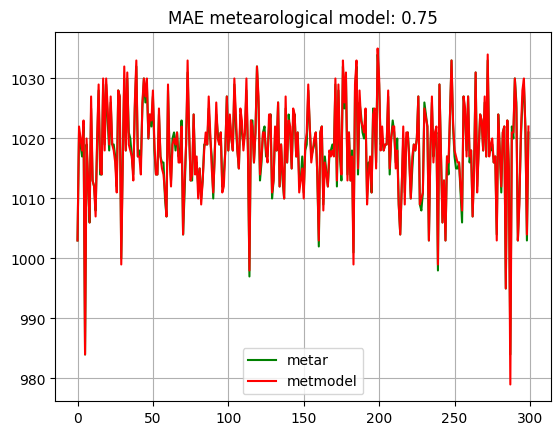

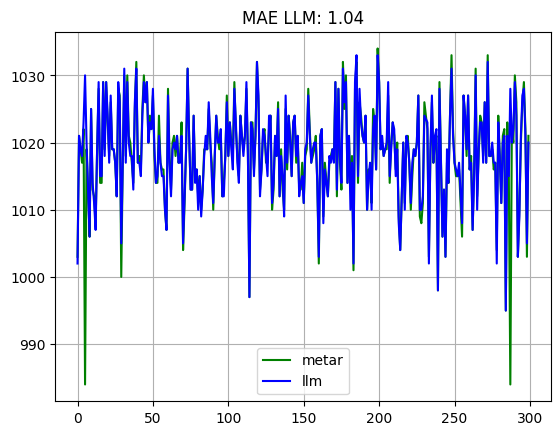

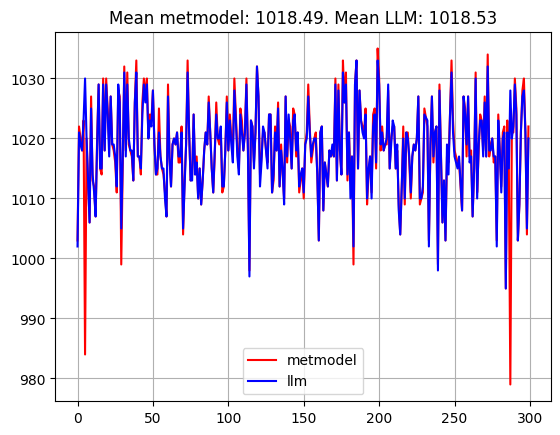

In [4]:
#@title QNH check

import pandas as pd
import numpy as np
pd.options.display.max_rows = 999

score = []

def flatten_list(list_s):
  numbers = []
  for sublist in list_s:
      for item in sublist:
          # Check if the string after 'q' is not empty
          if len(item) > 1:
              num = item[1:]
              if num.isdigit():
                  numbers.append(int(num))


  return np.array(numbers)

df = pd.read_csv(result_path)
q_ytest = []
q_ypred = []
q_metmod =[]
for i in range(0,len(df)):
  q_ytest.append([word for word in df["y_test"][i].split() if 'q' in word.lower()])
  q_ypred.append([word for word in df["y_pred"][i].split() if 'q' in word.lower()][:1])
  q_metmod.append([word for word in df["all"][i].split() if 'q' in word.lower()][:1])

q_ypred_f = []

for sublist in q_ypred:
    if not sublist:  # Check if the sublist is empty
        q_ypred_f.append(["q0000"])
    else:
        q_ypred_f.append(sublist)  # Append the single string element


q_ypred_n = flatten_list(q_ypred_f)
q_test_n = flatten_list(q_ytest)
q_metmod_n = flatten_list(q_metmod)


#Show results
df_res = pd.DataFrame({"metar":q_test_n,"metmodel":q_metmod_n,"llm":q_ypred_n})

#avoid 0
df_res = df_res[df_res.llm!=0]
mae_llm = round((df_res['metar'] - df_res['llm']).abs().mean(),2)
mae_metmod = round(np.mean(np.abs(q_metmod_n - q_test_n)),2)

score.append(mae_llm)
score.append(mae_metmod)

df_res[["metar","metmodel"]].plot(grid=True, color=['green', 'red'],title="MAE metearological model: {}".format(mae_metmod));
df_res[["metar","llm"]].plot(grid=True, color=['green', 'blue'],title="MAE LLM: {}".format(mae_llm));
df_res[["metmodel","llm"]].plot(grid=True, color=['red', 'blue'],title="Mean metmodel: {}. Mean LLM: {}".format(round(q_metmod_n.mean(),2),round(df_res.llm.mean(),2)));

In [5]:
#@title wind check

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.options.display.max_rows = 999

def contains_vrb(column):
    return column.str.contains('VRB', case=False, na=False)

def detect_wind_variation_test(metar):
    # Define a regex pattern for wind direction variation
    wind_variation_pattern = r'\b(\d{3})V(\d{3})\b'

    # Search for the wind direction variation in the METAR report
    match = re.search(wind_variation_pattern, metar)
    if match:
        dir1 = match.group(1)
        dir2 = match.group(2)
        return dir1,dir2
    else:
        return -1,-1

def detect_wind_variation_llm(metar):
    # Define a regex pattern for wind direction variation
    wind_variation_pattern = r'\b(\d{3})v(\d{3})\b'

    # Search for the wind direction variation in the METAR report
    match = re.search(wind_variation_pattern, metar)
    if match:
        dir1 = match.group(1)
        dir2 = match.group(2)
        return dir1,dir2
    else:
        return -1,-1


# Function to extract wind direction, speed, and gusts
def extract_wind_llm(metar):
    # Define a regex pattern for wind direction, intensity, and gusts
    # Also include a pattern for variable wind direction (VRB)
    wind_pattern = r'\b(vrb|\d{3})(\d{2})(g\d{2})?kt\b'

    # Search for the wind information in the METAR report
    match = re.search(wind_pattern, metar)
    if match:
        wind_direction = match.group(1)
        wind_speed = match.group(2)
        wind_gust = match.group(3) if match.group(3) else 0
        return wind_direction, wind_speed, wind_gust
    else:
        return "Wind information not found"


def extract_wind_test(metar):
    # Define a regex pattern for wind direction, intensity, and gusts
    # Also include a pattern for variable wind direction (VRB)
    wind_pattern = r'\b(VRB|\d{3})(\d{2})(G\d{2})?KT\b'

    # Search for the wind information in the METAR report
    match = re.search(wind_pattern, metar)
    if match:
        wind_direction = match.group(1)
        wind_speed = match.group(2)
        wind_gust = match.group(3) if match.group(3) else 0
        return wind_direction, wind_speed, wind_gust
    else:
        return "Wind information not found"

dirtest, modtest, gtest =[],[],[]
dirllm, modllm, gllm =[],[],[]

df = pd.read_csv(result_path)

for i in range(0,len(df)):
  wind_info_test = extract_wind_test(df["y_test"][i])
  wind_info_llm = extract_wind_llm(df["y_pred"][i])

  if isinstance(wind_info_test, tuple):
    dir, mod, gust = wind_info_test
    dirtest.append(dir)
    modtest.append(mod)
    gtest.append(gust)

  else:
    print(wind_info_test)
    dirtest.append(np.nan)
    modtest.append(np.nan)
    gtest.append(np.nan)

  if isinstance(wind_info_llm, tuple):
    dir, mod, gust = wind_info_llm
    dirllm.append(dir)
    modllm.append(mod)
    gllm.append(gust)

  else:
    print(wind_info_llm,i)
    dirllm.append(np.nan)
    modllm.append(np.nan)
    gllm.append(np.nan)

df["dirtest"]=dirtest
df["modtest"]=modtest
df["gtest"]=gtest

df["dirllm"]=dirllm
df["modllm"]=modllm
df["gllm"]=gllm

for i in range(0,len(df)):
  if "G" in str(df['gtest'][i]):
    df["gtest"][i]= int(df['gtest'][i][1:])

for i in range(0,len(df)):
  if "g" in str(df['gllm'][i]):
    df["gllm"][i]= int(df['gllm'][i][1:])

dirmetmod =[]
for i in range(0,len(df)):
  dirmetmod.append(int(df["all"][i].split()[0][:3]))
df["dirmetmod"] = dirmetmod

modmetmod =[]
for i in range(0,len(df)):
  modmetmod.append(int(df["all"][i].split()[0][3:5]))
df["modmetmod"] = modmetmod

dirvar = []
for i in range(0,len(df)):
  dirvar.append(detect_wind_variation_test(df["y_test"][i]))
df["dirvartest"] = dirvar

dirvar = []
for i in range(0,len(df)):
  dirvar.append(detect_wind_variation_llm(df["y_pred"][i]))
df["dirvarllm"] = dirvar
df.set_index("time")

#Analytics
mask_dirtest = contains_vrb(df['dirtest'])
mask_dirllm = contains_vrb(df['dirllm'])

# Combine the masks to filter rows
df_dir = df[~(mask_dirtest | mask_dirllm)][["dirtest","dirllm","dirmetmod"]].dropna().astype(int)

mae = int(np.mean(np.abs(df_dir['dirtest'] - df_dir['dirmetmod'])))
print(f"Mean Absolute Error (degrees) wind direction metmodel and metar: {mae}")
score.append(mae)
#MAE dir no vrb llm metar
mae = int((np.mean(np.abs(df_dir['dirtest'] - df_dir['dirllm']))))
print(f"Mean Absolute Error (degrees) wind direction llm and metar: {mae}")
score.append(mae)
df_mod= df[['modmetmod',"modtest","modllm"]].dropna().astype(int)

mae = round(np.mean(np.abs(df_mod['modtest'] - df_mod['modmetmod'])),2)
print(f"Mean Absolute Error (Kt) wind intensity metmodel and metar: {mae}")
score.append(mae)

#MAE dir no vrb llm metar
mae = round(np.mean(np.abs(df_mod['modtest'] - df_mod['modllm'])),2)
print(f"Mean Absolute Error (kt) wind intensity llm and metar: {mae}")
score.append(mae)

dirvary = sum([1 if (df["dirvarllm"][c][0]!=-1) & (df["dirvartest"][c][0]!=-1) else 0 for c in range(0,len(df))])
dirvarn = sum([1 if (df["dirvarllm"][c][0]==-1) & (df["dirvartest"][c][0]==-1) else 0 for c in range(0,len(df))])
print("Both metar and forecast direction variation:", round(dirvary/len(df),2))
print("Both metar and forecast no direction variation:",round(dirvarn/len(df),2))
print("No match between metar and forecast:", round((len(df)-dirvary-dirvarn)/len(df),2))

display(df.set_index("time")[["dirtest","dirllm","dirmetmod","dirvartest","dirvarllm", "modtest",	"modmetmod","modllm","gtest","gllm"]].head(20))

Mean Absolute Error (degrees) wind direction metmodel and metar: 39
Mean Absolute Error (degrees) wind direction llm and metar: 43
Mean Absolute Error (Kt) wind intensity metmodel and metar: 4.05
Mean Absolute Error (kt) wind intensity llm and metar: 2.11
Both metar and forecast direction variation: 0.5
Both metar and forecast no direction variation: 0.21
No match between metar and forecast: 0.29


,dirtest,dirllm,dirmetmod,dirvartest,dirvarllm,modtest,modmetmod,modllm,gtest,gllm
time,,,,,,,,,,
2021-05-09 14:00:00,260,260,250,"(210, 300)","(210, 320)",13,19,11,24,0
2019-01-17 01:00:00,310,vrb,360,"(-1, -1)","(-1, -1)",02,3,01,0,0
2022-01-05 08:00:00,200,300,210,"(160, 230)","(-1, -1)",08,9,02,0,0
2021-05-28 08:00:00,350,vrb,0,"(310, 040)","(-1, -1)",05,7,02,0,0
2021-10-09 22:00:00,050,vrb,30,"(010, 100)","(-1, -1)",03,9,02,0,0
2018-03-02 18:00:00,260,240,220,"(200, 310)","(200, 280)",12,21,12,0,0
2021-08-09 21:00:00,020,vrb,10,"(350, 050)","(-1, -1)",03,7,02,0,0
2021-11-25 12:00:00,050,060,50,"(360, 090)","(010, 110)",11,15,08,0,0
2019-04-07 16:00:00,130,150,130,"(100, 160)","(-1, -1)",07,11,11,0,0


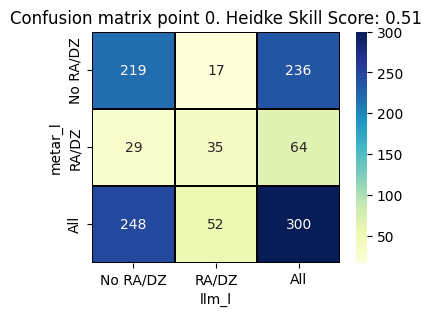

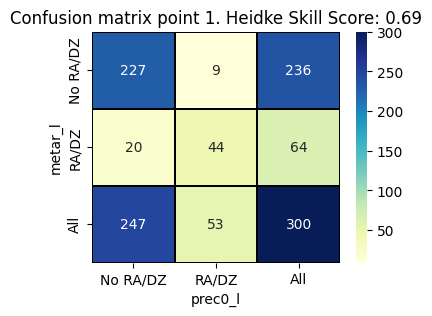

In [6]:
#@title Precipitation check

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 100)
df = pd.read_csv(result_path)

df["metar_l"] = "No RA/DZ"
mask = df['y_test'].str.contains("RA")
df.loc[mask,["metar_l"]] = "RA/DZ"
mask = df['y_test'].str.contains("DZ")
df.loc[mask,["metar_l"]] = "RA/DZ"

df["llm_l"] = "No RA/DZ"
mask = df['y_pred'].str.contains("ra")
df.loc[mask,["llm_l"]] = "RA/DZ"
mask = df['y_pred'].str.contains("dz")
df.loc[mask,["llm_l"]] = "RA/DZ"

df["prec0_l"] = "No RA/DZ"
mask = df['all'].str.contains("prec0y")
df.loc[mask,["prec0_l"]] = "RA/DZ"

# Confussion matrix and Heidke skill score
cm0 = pd.crosstab(df.metar_l, df.llm_l,margins=True)
a = cm0.values[0,0]
b = cm0.values[1,0]
c = cm0.values[0,1]
d = cm0.values[1,1]
HSS0 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)
score.append(HSS0)

cm1 = pd.crosstab(df.metar_l, df.prec0_l,margins=True)
a = cm1.values[0,0]
b = cm1.values[1,0]
c = cm1.values[0,1]
d = cm1.values[1,1]
HSS1 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)
score.append(HSS1)

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0. Heidke Skill Score: {}".format(HSS0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 1. Heidke Skill Score: {}".format(HSS1))
seab1 = sns.heatmap(cm1,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()


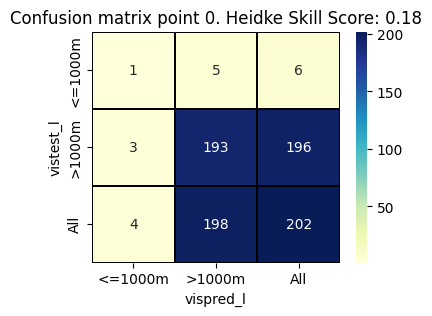

In [7]:
#@title Visibility check

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 999

def extract_visibility(metar):
    # Check if 'CAVOK' is in the METAR report
    if 'CAVOK' in metar:
        return '9999'
    if "cavok" in metar:
        return "9999"
    # Define a regex pattern for visibility
    visibility_pattern = r'\b(\d{4}|(\d+/\d+)?SM)\b'

    # Search for the visibility in the METAR report
    match = re.search(visibility_pattern, metar)
    if match:
        return int(match.group(0))
    else:
        return "Visibility information not found"

df = pd.read_csv(result_path)

vistest = []
vispred = []
for i in range(0,len(df)):
  vistest.append(extract_visibility(df["y_test"][i]))
  vispred.append(extract_visibility(df["y_pred"][i]))

df["vistest"]= vistest
df["vispred"]= vispred
df[['y_test', 'y_pred', 'all', 'vistest', 'vispred']]


#visibility to interval
interval = pd.IntervalIndex.from_tuples([(-0.1,1000), (1000, 40000)])
labels = ['<=1000m', '>1000m']
df["vistest_l"] = pd.cut(df["vistest"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")
df["vispred_l"] = pd.cut(df["vispred"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")

cm0 = pd.crosstab(df.vistest_l, df.vispred_l,margins=True)
a = cm0.values[0,0]
b = cm0.values[1,0]
c = cm0.values[0,1]
d = cm0.values[1,1]
HSS0 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)
score.append(HSS0)

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0. Heidke Skill Score: {}".format(HSS0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

In [8]:
#@title Temperature check

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def extract_temperature_test(metar):
    # Define a regex pattern to match the temperature (TT/DD)
    temperature_pattern = r'\b(M?\d{2})/(M?\d{2})\b'

    # Search for the temperature pattern in the METAR report
    match = re.search(temperature_pattern, metar)
    if match:
        temperature = match.group(1)
        if 'M' in temperature:
            temperature = -int(temperature.replace('M', ''))
        else:
            temperature = int(temperature)
        return temperature
    else:
        return None


def extract_temperature_llm(metar):
    # Define a regex pattern to match the temperature (TT/DD)
    temperature_pattern = r'\b(m?\d{2}) (m?\d{2})\b'

    # Search for the temperature pattern in the METAR report
    match = re.search(temperature_pattern, metar)
    if match:
        temperature = match.group(1)
        if 'm' in temperature:
            temperature = -int(temperature.replace('m', ''))
        else:
            temperature = int(temperature)
        return temperature
    else:
        return None


templlm,tempmetar,tempmetmod, tempmetmodraw =[],[],[],[]
for i in range (0,len(df)):
  tempmetar.append(extract_temperature_test(df["y_test"][i]))
  templlm.append(extract_temperature_llm(df["y_pred"][i]))
  tempmetmodraw.append(df["all"][i].split()[5])

tempmetmod = [-int(temperature.replace('M', '')) if 'M' in temperature else int(temperature) for temperature in tempmetmodraw]
df_temp=pd.DataFrame({"tempmetar":tempmetar,"templlm":templlm,"tempmetmod":tempmetmod}).dropna()


mae = round(np.mean(np.abs(df_temp['tempmetar'] - df_temp['tempmetmod'])),2)
std = round((df_temp['tempmetar'] - df_temp['tempmetmod']).std(),2)
print(f"Mean Absolute Error (degrees) temperature metmodel and metar: {mae}")
print(f"Standard desviation differences (degrees) temperature metmodel and metar: {std}")
score.append(mae)
score.append(std)

#MAE dir no vrb llm metar
mae = round(np.mean(np.abs(df_temp['tempmetar'] - df_temp['templlm'])),2)
std = round((df_temp['tempmetar'] - df_temp['templlm']).std(),2)
print(f"Mean Absolute Error temperature (degreees) llm and metar: {mae}")
print(f"Standard desviation differences (degrees) temperature LLM and metar: {std}")
score.append(mae)
score.append(std)
df_temp.head(20)

Mean Absolute Error (degrees) temperature metmodel and metar: 1.23
Standard desviation differences (degrees) temperature metmodel and metar: 1.62
Mean Absolute Error temperature (degreees) llm and metar: 1.22
Standard desviation differences (degrees) temperature LLM and metar: 1.68


,tempmetar,templlm,tempmetmod
0,13,15.0,15
1,4,3.0,3
2,7,5.0,7
3,13,14.0,13
4,13,14.0,13
5,9,8.0,9
6,17,15.0,15
7,9,11.0,11
8,7,8.0,9
9,2,0.0,0


In [9]:
#@title Save score

df_score = pd.DataFrame(score,index=["MAE_QNH_llm","MAE_QNH_metmodel","MAE_dir_metmodel",
                          "MAE_dir_llm","MAE_wind_int_metmodel","MAE_wind_int_llm",
                          "HSS_prec_llm","HSS_prec_metmodel","HHS_vis_llm","MAE_temp_metmodel","Std_temp_diff_metmodel",
                          "MAE_temp_llm","Std_temp_diff_metmodel"], columns=["Score"])
score_path = "/content/drive/MyDrive/Colab Notebooks/gpt/LEST/LESTscore.csv"
df_score.to_csv(score_path)

In [10]:
df_score

,Score
MAE_QNH_llm,1.04
MAE_QNH_metmodel,0.75
MAE_dir_metmodel,39.00
MAE_dir_llm,43.00
MAE_wind_int_metmodel,4.05
MAE_wind_int_llm,2.11
HSS_prec_llm,0.51
HSS_prec_metmodel,0.69
HHS_vis_llm,0.18
MAE_temp_metmodel,1.23
